# Modules and wrangling

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from matplotlib.ticker import ScalarFormatter as mpl_ScalarFormatter
#from adjustText import adjust_text
import textwrap
%matplotlib inline

cwd = '/rds/projects/c/chandjsz-analogy-automatedanalytics/281Cond/'

os.chdir(cwd)

In [2]:
addendum = ''# (1)'

output_dir = 'out/'

mean = 'Geometric' #Arithmetic or Geometric

mean_dir = output_dir+'Average_'+mean
figure_dir = output_dir + 'Publish/Figures/'
prev_dsr_directory = ''#prev/'
inc_dsr_directory = ''#inc/'

df = pd.read_csv(mean_dir+'/281 conditions chi2 z-scores, expected and observed rates.csv')

df_means = pd.read_csv(mean_dir+'/281 conditions yearly subgroup-overall ratios.csv')

df_means = df_means.set_index(['Unnamed: 0','Group']).stack().reset_index()
df_means.columns = ['Measure','Group','Date','Ratio']

sns.set_context('talk')
sns.set_style('whitegrid')

group_col = 'Group'
category_col = 'Subgroup'
condition_col = 'Condition'
date_col = 'Date'
col_variables = [condition_col,
                 category_col,
                 group_col]
headline_date = '2019'
df.Date = df.Date.str[:4]
df_means.Date = df_means.Date.str[:4]

ethmeans = pd.Series({"'BLACK'":1.3996,
                      "'ASIAN'":0.997,
                      "'WHITE'":1.001})

condition_labels = pd.read_excel('data/aurumGoldLabels_NCQOF.xlsx',
    header=3).dropna(subset=['Joht Labelling'])

# Utility functions

In [3]:
#%% chi2 limits for a given range and mean ratio. 
#This provides coordinates for the funnel plot lines around a mean ratio of 1. 
#These lines can be shifted for different subgroups by multiplying by the mean

def chi2_event_intervals(alpha,events):
    """ return observation limits for an expected count of events"""
    lower_lim_events = ss.chi2.ppf(alpha/2,df=2*events)/2
    upper_lim_events = ss.chi2.ppf(1-alpha/2,df=2*(events+1))/2

    return [upper_lim_events, lower_lim_events]

def chi2_rate_intervals(events,upper_lim_events,lower_lim_events):
    """ return rate limits for an expected count of events"""

    rate_ul = events/upper_lim_events
    rate_ll = events/lower_lim_events

    return [1, rate_ul, rate_ll]

def chi2_intervals(alpha,events):
    upper_lim_events, lower_lim_events = chi2_event_intervals(alpha,events)
    return chi2_rate_intervals(events,upper_lim_events,lower_lim_events)


def generate_limits(range_size,alpha):
    """Create a dataframe of coordinates for the funnel plot control limits.
    Input:  y axis max height for numerator, 
            alpha value for control limit (i.e. p-value for a z-score)
    Output: dataframe with y axis upper and lower control limit points for a given ratio"""
    
    cis_dict = {}
    for i in range(range_size):
    #rate, rate_ul, rate_ll = chi2_intervals(alpha,i,denom)
        cis_dict[i] = chi2_intervals(alpha,i)

    return pd.DataFrame(cis_dict,index=['Rate','Rate_UL','Rate_LL']).transpose()

In [4]:
idx = pd.IndexSlice

# top 5 conditions

### Bump Plots

In [5]:
dates = ['2006',
         '2019',
         #'2021'
        ]
inc = pd.read_csv(output_dir+inc_dsr_directory+'inc_DSR.csv') #inc and prev dfs only used in top5 conditions
inc.Year = inc.Year.str[:4]
inc = inc[(inc.Group=='Overall')&(inc.Year.isin(dates))
         ]
inc = inc.replace('AllergicOrChronic Rhinitis','Allergic or chronic rhinitis')

prev = pd.read_csv(output_dir+prev_dsr_directory+'prev_DSR.csv')
prev.Year = prev.Year.str[:4]
prev = prev[(prev.Group=='Overall')&(prev.Year.isin(dates))
           ]
prev = prev.replace('AllergicOrChronic Rhinitis','Allergic or chronic rhinitis')
prev.head()

,Condition,Subgroup,Year,Group,LowerCI,Prevalence,UpperCI
692,Malignant Neoplasm of Skin (excluding basal ce...,Overall,2006,Overall,319.050141,324.488609,329.994155
2357,Malignant Neoplasm of Skin (excluding basal ce...,Overall,2019,Overall,785.324641,801.295713,817.466167
3275,Abdominal Aortic Aneurysm,Overall,2006,Overall,90.884525,93.900439,96.988728
4940,Abdominal Aortic Aneurysm,Overall,2019,Overall,134.877711,141.546935,148.416195
5858,Abdominal and Inguinal Hernia,Overall,2006,Overall,5391.143261,5411.719490,5432.352199


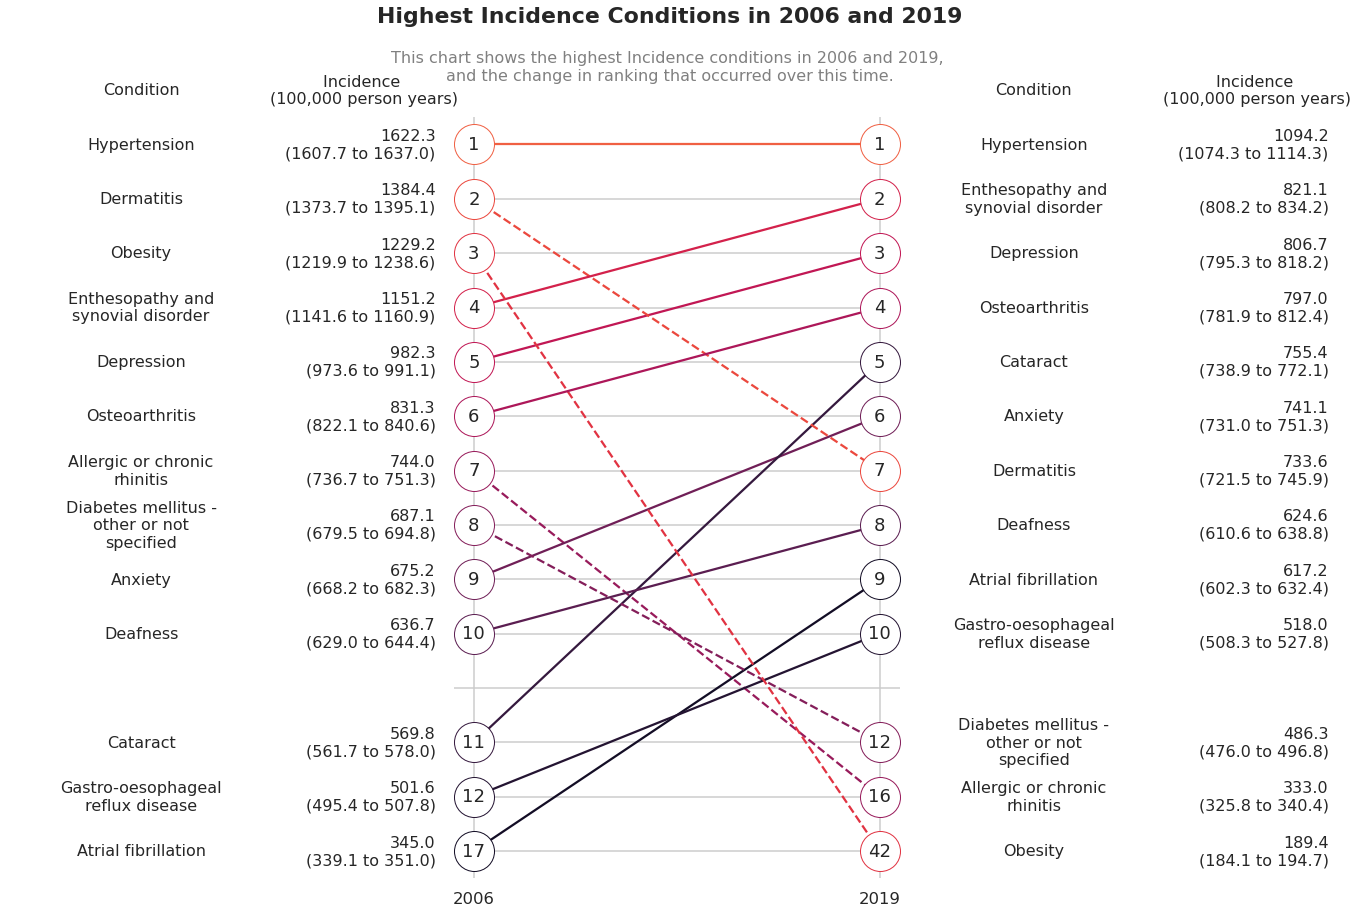

In [6]:
measure = 'Incidence'

ranked_inc = inc[['Condition','Year',measure,'LowerCI','UpperCI']].dropna()

n_top_ranked = 10
top_conditions_max = ranked_inc[ranked_inc["Year"] == ranked_inc["Year"].max()].nlargest(n_top_ranked, measure)
top_conditions_min = ranked_inc[ranked_inc["Year"] == ranked_inc["Year"].min()].nlargest(n_top_ranked, measure)

included_conditions = set(top_conditions_min.Condition.tolist()+top_conditions_max.Condition.tolist())

ranked_inc['ActualRank'] = (inc[['Condition','Year',measure]]
                            .dropna()
                            .sort_values(by=measure,ascending=False)
                            .groupby("Year")[measure]
                            .rank("first", ascending=False)
     
    #.rename("rank")
    #.sort_index()
    #.reset_index()
    #.head(10)
).astype(int)

ranked_inc['PlotRank'] = (inc[inc.Condition.isin(included_conditions)][['Condition','Year',measure]]
    .sort_values(by=measure,ascending=False)
    .groupby("Year")[measure]
    .rank("first", ascending=False)
     
    #.rename("rank")
    #.sort_index()
    #.reset_index()
    #.head(10)
).astype(int)

ranked_inc['PlotRank'] = [i+1 if i>10 else i for i in ranked_inc.PlotRank]

ranked_inc[measure] = (ranked_inc[measure]).round(1)
ranked_inc['LowerCI'] = (ranked_inc['LowerCI']).round(1)
ranked_inc['UpperCI'] = (ranked_inc['UpperCI']).round(1)

ranked_inc.style.format({measure: "{:,.0f}", "LowerCI": "{:,.0f}", "UpperCI": "{:,.0f}"})

est_with_cis = []
for i in ranked_inc.index:
    est_with_cis.append(''.join([ranked_inc.loc[i,measure].astype(str),
             '\n(' + ranked_inc.loc[i,'LowerCI'].astype(str),
             ' to ', ranked_inc.loc[i,'UpperCI'].astype(str), ')']))
ranked_inc[measure +' (CIs)'] = est_with_cis

ranked_inc = ranked_inc[ranked_inc.Condition.isin(included_conditions)]
ranked_inc.Condition = [textwrap.fill(i, width=20) for i in ranked_inc.Condition.str.capitalize().values]

ranked_inc.loc[0] = ['','2006','','','','',11,'']
ranked_inc.loc[1] = ['','2019','','','','',11,'']

n_conditions = len(included_conditions) + 1

from matplotlib.ticker import MultipleLocator, FixedFormatter, FixedLocator

fig, ax = plt.subplots(figsize=(8, n_conditions), subplot_kw=dict(ylim=(0.5, 0.5 + n_conditions))
                      )

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))

##### lines ##########################################################

palette = sns.color_palette("rocket", 20)
counter = 0

color_dict = dict(zip(ranked_inc[ranked_inc.Year==ranked_inc.Year.min()].sort_values(by='PlotRank',
                                                                                    ascending=False).Condition.values,
         palette))

for i, j in ranked_inc[['Condition','Year',measure,'ActualRank','PlotRank']].groupby("Condition"):
    #display(i,j)
    if j.iloc[0,0]=='':
            pass
    elif j.iloc[0,3]>=j.iloc[1,3]:
        ax.plot("Year", "PlotRank", "o-", data=j, mfc="w",ms=40,c=color_dict[i]
               )
    else:
        ax.plot("Year", "PlotRank", "o--", data=j, mfc="w",ms=40,c=color_dict[i]
               )
    for k in j.index:
        ax.annotate(text=j.loc[k,'ActualRank'],
                    xy=(j.loc[k,'Year'],j.loc[k,'PlotRank']),
                    ha='center',
                    va='center',
                    #c=color_dict[i]
                   )
    counter+=1
                
ax.axes.yaxis.set_ticklabels([])

##### tables ###########################################################
width = 1

def set_align_for_column(table, col, align="left"):
    cells = [key for key in table._cells if key[1] == col]
    for cell in cells:
        table._cells[cell]._loc = align
        table._cells[cell]._text.set_horizontalalignment(align) 
        
miny_inc = ranked_inc[ranked_inc.Year==ranked_inc.Year.min()][[#'Rank',
                                                    'Condition','PlotRank',measure+' (CIs)'
                                                   ]].sort_values(by='PlotRank',
                                                                   ascending=True)

maxy_inc = ranked_inc[ranked_inc.Year==ranked_inc.Year.max()][[#'Rank',
                                                    'Condition','PlotRank',measure +' (CIs)'
                                                   ]].sort_values(by='PlotRank',
                                                                    ascending=True)

right_table = ax.table(cellText=maxy_inc.drop('PlotRank',axis=1).values, 
                       colLabels=[#'Rank',
                                'Condition','Incidence \n(100,000 person years)'], 
                       loc='right',
                       bbox = [1.0, 0, width,1+1/n_conditions],
                      edges='open',
                     colWidths=[0.3,0.2])
       
        
left_table = ax.table(cellText=miny_inc.drop('PlotRank',axis=1).values, 
                      colLabels=['Condition','Incidence \n(100,000 person years)'],#'Rank'
                                
                      #rowLabels=max_inc.Condition.values,
                      loc='right',
                      bbox = [-width, 0, width,1+1/n_conditions],
                      edges='open',
                     colWidths=[0.3,0.2])

set_align_for_column(left_table, col=0, align="center")
set_align_for_column(right_table, col=0, align="center")
        
right_table.auto_set_font_size(False)
right_table.set_fontsize(16)
#right_table.scale(5, 1.5)

left_table.auto_set_font_size(False)
left_table.set_fontsize(16)

    
############ figure aesthetics ##########
ax.invert_yaxis()
#ax.set(xlabel="Year",title="Highest Incidence Conditions in 2006 and 2019")

# Adding the bold header as a text annotation using \n to create a new line
header_text = "Highest " + measure + " Conditions in 2006 and 2019"
header_props = {'fontsize': 22, 'fontweight': 'bold', 'va': 'center', 'ha': 'center'}
# Adjusting the y-coordinate to bring the header closer to the table
plt.text(0.5, 0.98, header_text, transform=fig.transFigure, **header_props)

# Adding the subtitle at the top in gray
subtitle_text = "This chart shows the highest "+measure+" conditions in 2006 and 2019, \nand the change in ranking that occurred over this time."
subtitle_props = {'fontsize': 16, 'va': 'center', 'ha': 'center', 'color': 'gray'}
plt.text(0.5, 0.93, subtitle_text, transform=fig.transFigure, **subtitle_props)

#ax.grid(axis="x")
sns.despine(left=True,bottom=True)
plt.savefig(figure_dir +'Inc Bump.png',bbox_inches='tight')

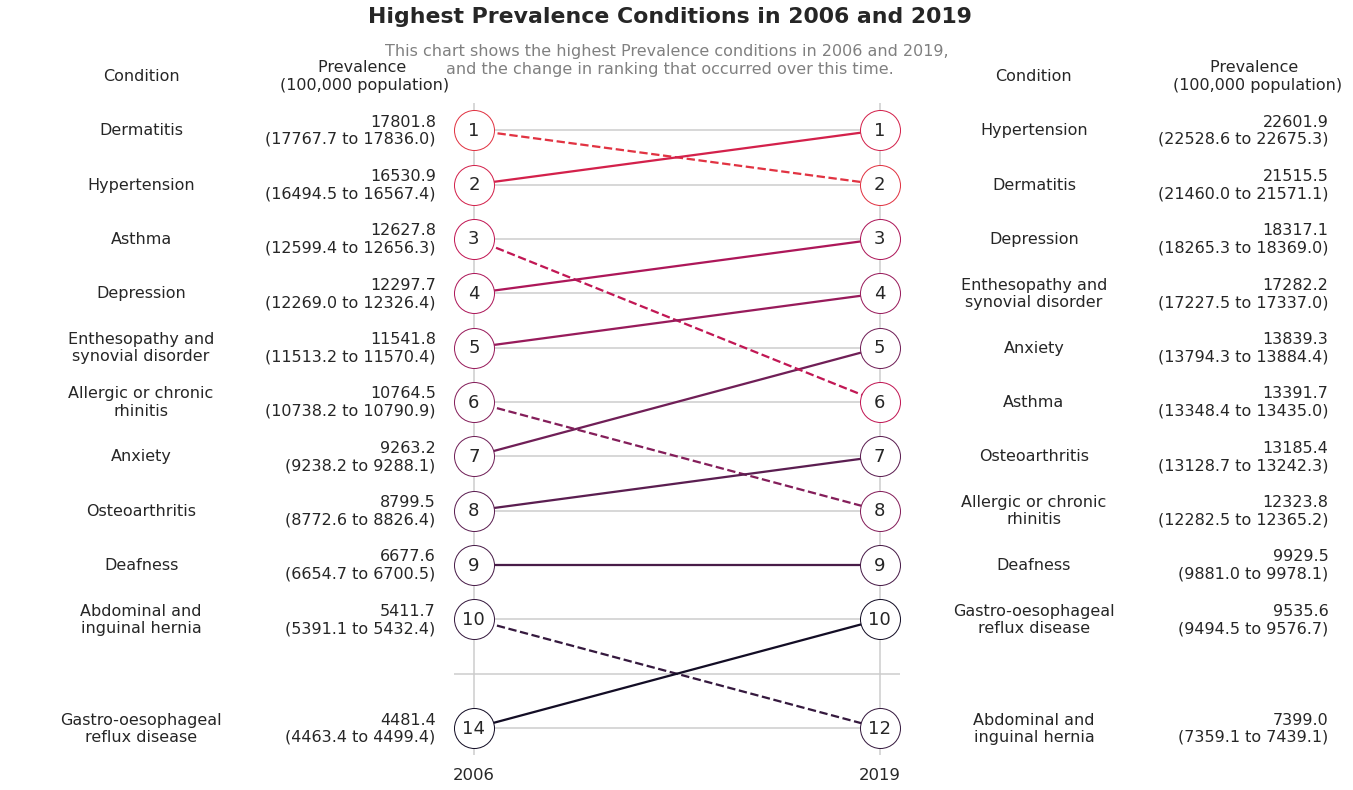

In [7]:
measure = 'Prevalence'

ranked_prev = prev[['Condition','Year',measure,'LowerCI','UpperCI']].dropna()

n_top_ranked = 10
top_conditions_max = ranked_prev[ranked_prev["Year"] == ranked_prev["Year"].max()].nlargest(n_top_ranked, measure)
top_conditions_min = ranked_prev[ranked_prev["Year"] == ranked_prev["Year"].min()].nlargest(n_top_ranked, measure)

included_conditions = set(top_conditions_min.Condition.tolist()+top_conditions_max.Condition.tolist())

ranked_prev['ActualRank'] = (prev[['Condition','Year',measure]]
                            .dropna()
                            .sort_values(by=measure,ascending=False)
                            .groupby("Year")[measure]
                            .rank("first", ascending=False)
     
    #.rename("rank")
    #.sort_index()
    #.reset_index()
    #.head(10)
).astype(int)

ranked_prev['PlotRank'] = (prev[prev.Condition.isin(included_conditions)][['Condition','Year',measure]]
    .sort_values(by=measure,ascending=False)
    .groupby("Year")[measure]
    .rank("first", ascending=False)
     
    #.rename("rank")
    #.sort_index()
    #.reset_index()
    #.head(10)
).astype(int)

ranked_prev['PlotRank'] = [i+1 if i>10 else i for i in ranked_prev.PlotRank]

ranked_prev[measure] = (ranked_prev[measure]).round(1)
ranked_prev['LowerCI'] = (ranked_prev['LowerCI']).round(1)
ranked_prev['UpperCI'] = (ranked_prev['UpperCI']).round(1)

est_with_cis = []
for i in ranked_prev.index:
    est_with_cis.append(''.join([ranked_prev.loc[i,measure].astype(str),
             '\n(' + ranked_prev.loc[i,'LowerCI'].astype(str),
             ' to ', ranked_prev.loc[i,'UpperCI'].astype(str), ')']))
ranked_prev[measure +' (CIs)'] = est_with_cis

ranked_prev = ranked_prev[ranked_prev.Condition.isin(included_conditions)]
ranked_prev.Condition = [textwrap.fill(i, width=20) for i in ranked_prev.Condition.str.capitalize().values]

ranked_prev.loc[0] = ['','2006','','','','',11,'']
ranked_prev.loc[1] = ['','2019','','','','',11,'']

n_conditions = len(included_conditions) + 1

from matplotlib.ticker import MultipleLocator, FixedFormatter, FixedLocator

fig, ax = plt.subplots(figsize=(8, n_conditions), subplot_kw=dict(ylim=(0.5, 0.5 + n_conditions))
                      )

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))

##### lines ##########################################################

palette = sns.color_palette("rocket", 20)
counter = 0

color_dict = dict(zip(ranked_prev[ranked_prev.Year==ranked_prev.Year.min()].sort_values(by='PlotRank',
                                                                                    ascending=False).Condition.values,
         palette))

for i, j in ranked_prev[['Condition','Year',measure,'ActualRank','PlotRank']].groupby("Condition"):
    #display(i,j)
    if j.iloc[0,0]=='':
            pass
    elif j.iloc[0,3]>=j.iloc[1,3]:
        ax.plot("Year", "PlotRank", "o-", data=j, mfc="w",ms=40,c=color_dict[i]
               )
    else:
        ax.plot("Year", "PlotRank", "o--", data=j, mfc="w",ms=40,c=color_dict[i]
               )
    for k in j.index:
        ax.annotate(text=j.loc[k,'ActualRank'],
                    xy=(j.loc[k,'Year'],j.loc[k,'PlotRank']),
                    ha='center',
                    va='center',
                    #c=color_dict[i]
                   )
    counter+=1
                
ax.axes.yaxis.set_ticklabels([])

##### tables ###########################################################
width = 1

def set_align_for_column(table, col, align="left"):
    cells = [key for key in table._cells if key[1] == col]
    for cell in cells:
        table._cells[cell]._loc = align
        table._cells[cell]._text.set_horizontalalignment(align) 
        
miny_prev = ranked_prev[ranked_prev.Year==ranked_prev.Year.min()][[#'Rank',
                                                    'Condition','PlotRank',measure+' (CIs)'
                                                   ]].sort_values(by='PlotRank',
                                                                   ascending=True)

maxy_prev = ranked_prev[ranked_prev.Year==ranked_prev.Year.max()][[#'Rank',
                                                    'Condition','PlotRank',measure +' (CIs)'
                                                   ]].sort_values(by='PlotRank',
                                                                    ascending=True)

right_table = ax.table(cellText=maxy_prev.drop('PlotRank',axis=1).values, 
                       colLabels=[#'Rank',
                                'Condition','Prevalence \n(100,000 population)'], 
                       loc='right',
                       bbox = [1.0, 0, width,1+1/n_conditions],
                      edges='open',
                     colWidths=[0.3,0.2])
       
        
left_table = ax.table(cellText=miny_prev.drop('PlotRank',axis=1).values, 
                      colLabels=['Condition','Prevalence \n(100,000 population)'],
                      loc='right',
                      bbox = [-width, 0, width,1+1/n_conditions],
                      edges='open',
                     colWidths=[0.3,0.2])

set_align_for_column(left_table, col=0, align="center")
set_align_for_column(right_table, col=0, align="center")
        
right_table.auto_set_font_size(False)
right_table.set_fontsize(16)
#right_table.scale(5, 1.5)

left_table.auto_set_font_size(False)
left_table.set_fontsize(16)

    
############ figure aesthetics ##########
ax.invert_yaxis()
#ax.set(xlabel="Year",title="Highest Incidence Conditions in 2006 and 2019")

# Adding the bold header as a text annotation using \n to create a new line
header_text = "Highest " + measure + " Conditions in 2006 and 2019"
header_props = {'fontsize': 22, 'fontweight': 'bold', 'va': 'center', 'ha': 'center'}
# Adjusting the y-coordinate to bring the header closer to the table
plt.text(0.5, 0.98, header_text, transform=fig.transFigure, **header_props)

# Adding the subtitle at the top in gray
subtitle_text = "This chart shows the highest "+measure+" conditions in 2006 and 2019, \nand the change in ranking that occurred over this time."
subtitle_props = {'fontsize': 16, 'va': 'center', 'ha': 'center', 'color': 'gray'}
plt.text(0.5, 0.93, subtitle_text, transform=fig.transFigure, **subtitle_props)

sns.despine(left=True,bottom=True)
plt.savefig(figure_dir +'Prev Bump.png',bbox_inches='tight')

In [8]:
ranked_inc.iloc[-1,0]==''

True

x Plot all included conditions for both years
    x create list of included conditions
    x create ActualRank and PlotRank
    x plot PlotRank, print ActualRank
- Divide top 10 from extras
x Change bump line colour to single gradient
x Change table edge colour
x Put rank in bubble and remove from table
x Make bump plot narrower
x Ensure titles are correctly bounded
x Give units for incidence
x Add confidence intervals to Incidence
x Alter table widths

/tmp/ipykernel_1957463/996866850.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ranked_prev['Rank'] = (prev[['Condition','Year','Prevalence']]


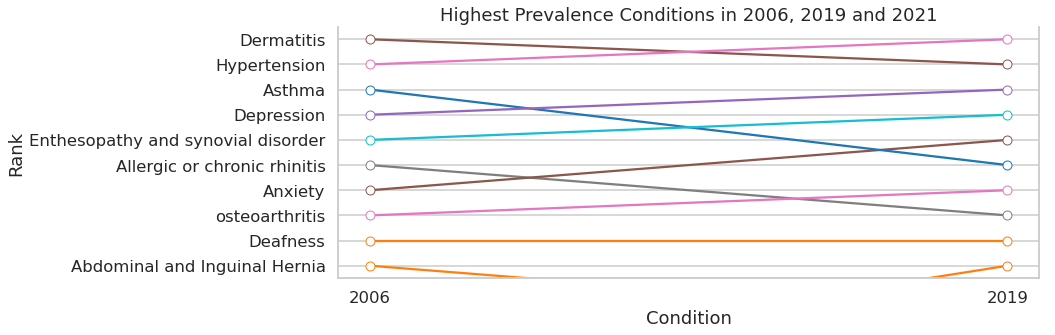

In [9]:
ranked_prev = prev[['Condition','Year','Prevalence']]
ranked_prev['Rank'] = (prev[['Condition','Year','Prevalence']]
    .sort_values(by='Prevalence',ascending=False)
    .groupby("Year")['Prevalence']
    .rank("first", ascending=False)
     
    #.rename("rank")
    #.sort_index()
    #.reset_index()
    #.head(10)
)

ranks = 10

#ranked_inc = ranked_inc.sort_values(by='Rank').head(ranks*3).sort_values(by='Year')

n_top_ranked = 10
top_conditions2021_prev = ranked_prev[ranked_prev["Year"] == '2021'].nsmallest(n_top_ranked, "Rank")
top_conditions2006_prev = ranked_prev[ranked_prev["Year"] == '2006'].nsmallest(n_top_ranked, "Rank")


from matplotlib.ticker import MultipleLocator, FixedFormatter, FixedLocator

fig, ax = plt.subplots(figsize=(15, 5), subplot_kw=dict(ylim=(0.5, 0.5 + n_top_ranked)))

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))

ax.yaxis.set_major_locator(FixedLocator(top_conditions2006_prev["Rank"].to_list()))
ax.yaxis.set_major_formatter(FixedFormatter(top_conditions2006_prev["Condition"].to_list()))

yax2 = ax.secondary_yaxis("right")
yax2.yaxis.set_major_locator(FixedLocator(top_conditions2021_prev["Rank"].to_list()))
yax2.yaxis.set_major_formatter(FixedFormatter(top_conditions2021_prev["Condition"].to_list()))

for i, j in ranked_prev.groupby("Condition"):
    #display(i,j)
    ax.plot("Year", "Rank", "o-", data=j, mfc="w")

ax.invert_yaxis()
ax.set(xlabel="Condition", ylabel="Rank", title="Highest Prevalence Conditions in 2006, 2019 and 2021")
ax.grid(axis="x")
sns.despine()
plt.tight_layout()

### Time Series

In [10]:
dates = ['2006','2019','2021']
inc = pd.read_csv(output_dir+inc_dsr_directory+'inc_DSR.csv') #inc and prev dfs only used in top5 conditions
inc.Year = inc.Year.str[:4].astype(int)
inc = inc[(inc.Group=='Overall')&(inc.Year>=2006)
         ]

prev = pd.read_csv(output_dir+prev_dsr_directory+'prev_DSR.csv')
prev.Year = prev.Year.str[:4]
prev = prev[(prev.Group=='Overall')#&(prev.Year.isin(dates))
           ]
prev.head()



,Condition,Subgroup,Year,Group,LowerCI,Prevalence,UpperCI
106,Malignant Neoplasm of Skin (excluding basal ce...,Overall,2001,Overall,189.250600,194.109435,199.060850
217,Malignant Neoplasm of Skin (excluding basal ce...,Overall,2002,Overall,211.451111,216.398576,221.431823
332,Malignant Neoplasm of Skin (excluding basal ce...,Overall,2003,Overall,234.115024,239.060874,244.083912
450,Malignant Neoplasm of Skin (excluding basal ce...,Overall,2004,Overall,263.371055,268.414740,273.529415
569,Malignant Neoplasm of Skin (excluding basal ce...,Overall,2005,Overall,300.539880,305.720248,310.965839


/tmp/ipykernel_1957463/1933657228.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ranked_inc['Rank'] = (inc[['Condition','Year','Incidence']]


<AxesSubplot:xlabel='Year', ylabel='Incidence'>

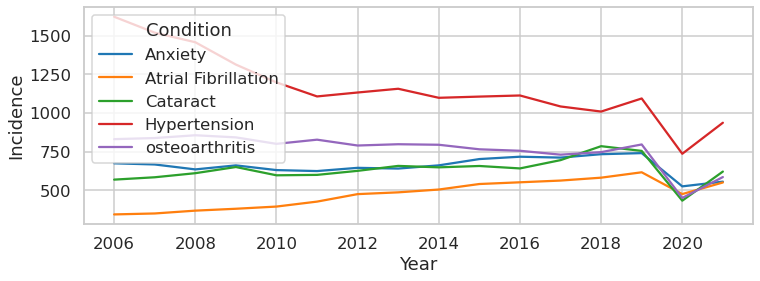

In [11]:
# 2021 top 5
ranked_inc = inc[['Condition','Year','Incidence']]
ranked_inc['Rank'] = (inc[['Condition','Year','Incidence']]
    .sort_values(by='Incidence',ascending=False)
    .groupby("Year")['Incidence']
    .rank("first", ascending=False)
     
    #.rename("rank")
    #.sort_index()
    #.reset_index()
    #.head(10)
)

ranks = 10

#ranked_inc = ranked_inc.sort_values(by='Rank').head(ranks*3).sort_values(by='Year')

n_top_ranked = 5
top_conditions2021 = ranked_inc[ranked_inc["Year"] == 2021].nsmallest(n_top_ranked, "Rank")
top_conditions2021 = list(top_conditions2021['Condition'].values)

inc2021 = inc[inc['Condition'].isin(top_conditions2021)][['Condition','Year','Incidence']]

fig,ax = plt.subplots(figsize=(12,4))
sns.lineplot(data=inc2021,x='Year',y='Incidence',
            hue='Condition',
            ax=ax)

/tmp/ipykernel_1957463/42865453.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ranked_inc['Rank'] = (inc[['Condition','Year','Incidence']]


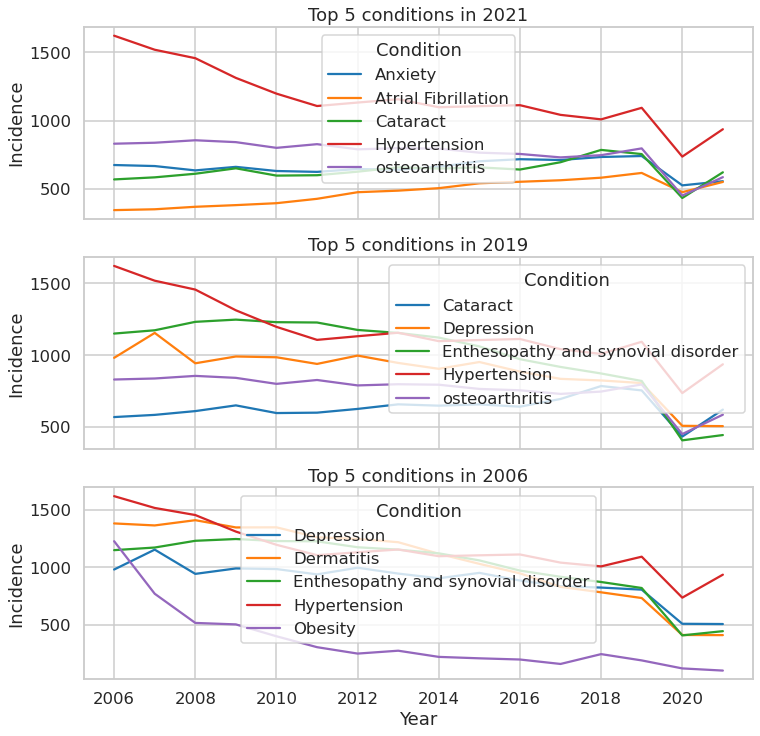

In [12]:
ranked_inc = inc[['Condition','Year','Incidence']]
ranked_inc['Rank'] = (inc[['Condition','Year','Incidence']]
    .sort_values(by='Incidence',ascending=False)
    .groupby("Year")['Incidence']
    .rank("first", ascending=False)
     
    #.rename("rank")
    #.sort_index()
    #.reset_index()
    #.head(10)
)

ranks = 10

#ranked_inc = ranked_inc.sort_values(by='Rank').head(ranks*3).sort_values(by='Year')

n_top_ranked = 5
fig,axs = plt.subplots(3,1,figsize=(12,12),
                     sharex=True)

top_conditions2021 = ranked_inc[ranked_inc["Year"] == 2021].nsmallest(n_top_ranked, "Rank")
top_conditions2021 = list(top_conditions2021['Condition'].values)
top_conditions2019 = ranked_inc[ranked_inc["Year"] == 2019].nsmallest(n_top_ranked, "Rank")
top_conditions2019 = list(top_conditions2019['Condition'].values)
top_conditions2006 = ranked_inc[ranked_inc["Year"] == 2006].nsmallest(n_top_ranked, "Rank")
top_conditions2006 = list(top_conditions2006['Condition'].values)

inc2021 = inc[inc['Condition'].isin(top_conditions2021)][['Condition','Year','Incidence']]

sns.lineplot(data=inc2021,x='Year',y='Incidence',
            hue='Condition',
            ax=axs[0])
axs[0].title.set_text('Top 5 conditions in 2021')

inc2019 = inc[inc['Condition'].isin(top_conditions2019)][['Condition','Year','Incidence']]

sns.lineplot(data=inc2019,x='Year',y='Incidence',
            hue='Condition',
            ax=axs[1])
axs[1].title.set_text('Top 5 conditions in 2019')

inc2006 = inc[inc['Condition'].isin(top_conditions2006)][['Condition','Year','Incidence']]

sns.lineplot(data=inc2006,x='Year',y='Incidence',
            hue='Condition',
            ax=axs[2])
axs[2].title.set_text('Top 5 conditions in 2006')



#### NHSCore20PLUS5

<AxesSubplot:xlabel='Year', ylabel='Incidence'>

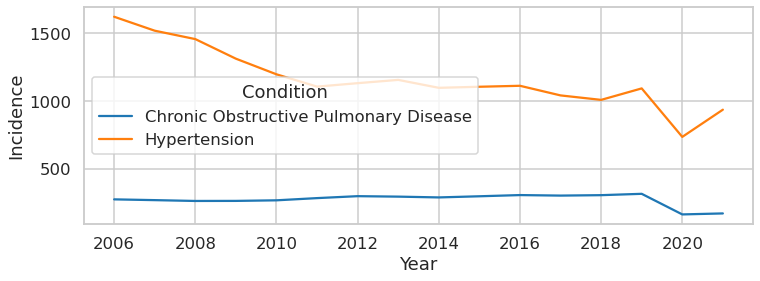

In [13]:
inc.Condition.unique()
c20plus5conditions = ['Chronic Obstructive Pulmonary Disease',
                     'Hypertension']

incc20plus5 = inc[inc['Condition'].isin(c20plus5conditions)][['Condition','Year','Incidence']]

fig,ax = plt.subplots(figsize=(12,4))
sns.lineplot(data=incc20plus5,x='Year',y='Incidence',
            hue='Condition',
            #ax=axs[0]
            )


### Bar Plots

In [14]:
date = '2021'
inc = pd.read_csv(output_dir+inc_dsr_directory+'inc_DSR.csv')
inc.Year = inc.Year.str[:4]
inc = inc[(inc.Group=='Overall')&(inc.Year==date)
         ]

prev = pd.read_csv(output_dir+prev_dsr_directory+'prev_DSR.csv')
prev.Year = prev.Year.str[:4]
prev = prev[(prev.Group=='Overall')&(prev.Year==date)
           ]
display(prev.head())

t5prev = prev.set_index('Condition')[[
    'Prevalence', 'LowerCI', 'UpperCI'
]].sort_values(by='Prevalence', ascending=False).head().sort_values(
    by='Prevalence', ascending=True) / 100

t5inc = inc.set_index('Condition')[[
    'Incidence', 'LowerCI', 'UpperCI'
]].sort_values(by='Incidence', ascending=False).head().sort_values(
    by='Incidence', ascending=True) / 100

,Condition,Subgroup,Year,Group,LowerCI,Prevalence,UpperCI
2582,Malignant Neoplasm of Skin (excluding basal ce...,Overall,2021,Overall,827.059866,845.348412,863.879898
5165,Abdominal Aortic Aneurysm,Overall,2021,Overall,139.390799,146.952926,154.759221
7748,Abdominal and Inguinal Hernia,Overall,2021,Overall,7333.223694,7377.538703,7422.011812
10331,Acne,Overall,2021,Overall,6689.352174,6717.574502,6745.882580
12914,Actinic keratosis,Overall,2021,Overall,3424.792937,3459.539537,3494.499471


In [15]:
def plot_bars(df,
             ax,barWidth = 0.4):
    
    measure = df.columns[0]
 
    # Choose the height of the blue bars
    bars1 = df[measure]
    
    # Choose the height of the error bars (bars1)
    xer1 = df['UpperCI'].subtract(bars1,axis=0)
    xer2 = df[measure]-df['LowerCI']
    xer = pd.concat([xer1,xer2],axis=1)
    
    # Bar Labels
    top_condition_names = list(df.index)
    top_condition_names = [condition.title() for condition in top_condition_names]
    top_condition_names = [textwrap.fill(i, width=20) for i in top_condition_names]
    
    #if 'Enthesopathy And Synovial Disorder' in top_condition_names.index:
    #    loc = top_condition_names.index('Enthesopathy And Synovial Disorder')
    #    top_condition_names[loc] = 'Enthesopathy And \nSynovial Disorder'
    
    # The x position of bars
    r1 = np.arange(len(bars1))
    
    # Create blue bars
    ax.barh(r1, bars1, height = barWidth, #color = 'light grey', 
             edgecolor = 'black',xerr=xer1, 
            capsize=7, #label='poacee'
           alpha=0.6)

    # general layout
    ax.xaxis.set_tick_params(labelbottom=False, labeltop=True, length=0)
    ax.set_yticks([r  for r in range(len(bars1))], top_condition_names)
    
    return ax

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


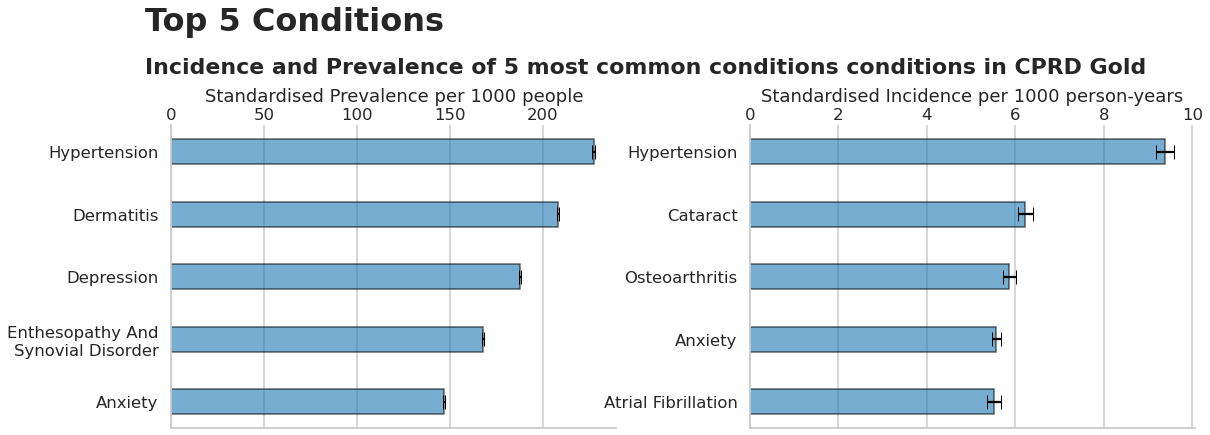

In [16]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(18,6))

t5prev.index = t5prev.index.str.title()

t5prev = t5prev.sort_values(by='Prevalence',
                           ascending=True)
sns.set_style('whitegrid')
sns.set_context('talk')


fig.subplots_adjust(left=0.21, right=1.0,
                    top=0.70, bottom=0.0
                   )

# width of the bars
barWidth = 0.4
 
plot_bars(t5prev,
             barWidth = barWidth,
             ax = ax1)

plot_bars(t5inc,
             barWidth = barWidth,
             ax = ax2)

ax1.grid(axis='y',
         visible=False)
ax2.grid(axis='y',
         visible=False)
# Show graphic
#ax.spines['bottom'].set_position('zero')
sns.despine(right=True)
#ax.get_legend().remove()

ha_text = 0.19
fig.text(
    ha_text, 0.92,
    'Top 5 Conditions', 
    fontsize=32, fontweight="bold", fontfamily="Malgun Gothic"
)


ha_text = 0.19
fig.text(
    ha_text, 0.82,
    'Incidence and Prevalence of 5 most common conditions conditions in CPRD Gold', 
    fontsize=22, fontweight="bold", #fontfamily="Econ Sans Cnd"
)

ax1.set_title(#ha_text, 
              #y=0.78, 
    label="Standardised Prevalence per 1000 people", 
    #fontsize=22, #fontfamily="Econ Sans Cnd"
)

ax2.set_title(#ha_text, 
              #y=0.78, 
    label="Standardised Incidence per 1000 person-years", 
    #fontsize=22, #fontfamily="Econ Sans Cnd"
)

#fig.savefig('Top 5 Prevalence')

plt.subplots_adjust(wspace=0.3, )
plt.savefig(figure_dir+'Top 5 Conditions Incidence and Prevalence.png')
plt.show()

In [17]:
selectrivation = ["'1'",
                  "'2'",
                  "'3'",
                  "'4'",
                  "'5'", 
                  "'6'",
                  "'7'",
                  "'8'",
                  "'9'",
                  "'10'"]
region_names = ["'East Midlands'",
       "'East of England'", "'London'", "'North East'", 
    "'North West'",
       "'Northern Ireland'", "'Scotland'", "'South East'", "'South West'",
       "'Wales'", "'West Midlands'", "'Yorkshire & The Humber'"]


df_means[(df_means.Measure=='Prevalence')&
         (df_means.Group.isin(region_names))&
         (df_means.Date==headline_date)]

,Measure,Group,Date,Ratio
883,Prevalence,'East of England',2019,1.277262
923,Prevalence,'London',2019,0.826958
982,Prevalence,'North West',2019,0.964201
1003,Prevalence,'Northern Ireland',2019,1.088874
1045,Prevalence,'Scotland',2019,0.995326
1066,Prevalence,'South East',2019,0.850887
1087,Prevalence,'South West',2019,1.044462
1128,Prevalence,'Wales',2019,0.987768
1149,Prevalence,'West Midlands',2019,0.960487
1170,Prevalence,'Yorkshire & The Humber',2019,0.662854


In [18]:
df[(df.Date==headline_date)&
  #(df.Measure=='Prevalence')&
         (df.Group.isin(region_names))&
  (df.Condition=='Obesity')]

,Unnamed: 0,Condition,Date,Group,Prevalence,Prevalence Ratio,Expected Prevalence,Prevalence Z-Score,Incidence,Incidence Ratio,Expected Incidence,Incidence Z-Score
107785,107785,Obesity,2019,'East of England',43.113387,0.601051,91.618041,-6.375242,24.681295,0.130338,284.942318,-inf
113029,113029,Obesity,2019,'London',55.363748,0.771835,59.317730,-0.481714,431.780770,2.280174,136.468731,16.576671
123517,123517,Obesity,2019,'North West',69.808178,0.973207,69.162200,-0.002511,85.308631,0.450503,170.633708,-8.076571
129313,129313,Obesity,2019,'Northern Ireland',85.803570,1.196201,78.105002,0.770113,167.856839,0.886428,194.106135,-1.952195
135109,135109,Obesity,2019,'Scotland',81.921652,1.142083,71.394770,1.112806,101.529501,0.536163,187.041921,-7.559661
140905,140905,Obesity,2019,'South East',48.848479,0.681005,61.034149,-1.634214,489.497847,2.584969,157.604507,17.467761
146701,146701,Obesity,2019,'South West',80.406062,1.120954,74.919274,0.543219,291.982434,1.541918,180.566464,6.974769
152221,152221,Obesity,2019,'Wales',66.166499,0.922438,70.852650,-0.529656,183.447218,0.968759,196.110725,-0.900576
158017,158017,Obesity,2019,'West Midlands',60.265605,0.840173,68.895766,-1.046018,228.233649,1.205270,174.139011,3.690560
163813,163813,Obesity,2019,'Yorkshire & The Humber',19.078436,0.265976,47.546576,-5.416521,14.699316,0.077625,171.083935,-inf


## Variation between IMD1 and IMD10 conditions

In [19]:
imd1_10 = pd.concat([df[df.Group=="'1'"].set_index(['Condition','Date']),
        df[df.Group=="'10'"].set_index(['Condition','Date'])],
         axis=1,keys=['IMD1','IMD10'])
prev_dif = imd1_10.loc[:,idx[:,'Prevalence Z-Score']].iloc[:,0] - imd1_10.loc[:,idx[:,'Prevalence Z-Score']].iloc[:,1]
inc_dif = imd1_10.loc[:,idx[:,'Incidence Z-Score']].iloc[:,0] - imd1_10.loc[:,idx[:,'Incidence Z-Score']].iloc[:,1]
pd.concat([prev_dif,inc_dif],
         axis=1,keys=['prev_dif','inc_dif',]
         ).replace([np.inf, -np.inf],
                   np.nan).dropna(how='any').sort_values(by='inc_dif').tail(100).head(10)

,,prev_dif,inc_dif
Condition,Date,,
Alcohol abuse,2019,-1.984940,5.176638
Polymyalgia Rheumatica,2012,1.057072,5.178625
Malignant Neoplasm of Skin (excluding basal cell carcinoma),2014,1.577930,5.207004
Pulmonary Collapse,2018,-0.319985,5.240940
Intervertebral Disc Disorder,2016,1.875894,5.242798
AllergicOrChronic Rhinitis,2004,1.555722,5.309583
Malignant Neoplasm of Skin (excluding basal cell carcinoma),2013,1.492054,5.311868
Polymyalgia Rheumatica,2004,0.580658,5.322560
Acne,2003,0.564113,5.365763


# Graph the funnel plot and label most positive z-scores

In [20]:
n = 300
df_lims2 = generate_limits(n,alpha=0.05)
df_lims3 = generate_limits(n,alpha=0.01)

measure_max = np.NaN

def funnel_plot_n_variables(group_dict,
                            df,
                            category_label,
                            risk_threshold,
                            measure,
                            denominator,
                            measure_min,
                            measure_max,
                            flagged_conditions = [],
                            date=headline_date,
                           label_n_conditions=3,
                           df_lims2_standard = df_lims2,
                           df_lims3_standard = df_lims3,
                           heads=True,
                           text_coord_options = [(3, measure_max*5/6),
                                  (5, measure_max*4/6),
                                  (8, measure_max*3/6),
                                  (13, measure_max*2/6),
                                  (21, measure_max*1/6),
                                  (3, measure_max*5/6)]):
    """create a funnel plot for 3 groups
       inputs: 
    group_dict     a dict of desired groups from the data paired with the label to appear in the graph
    df             the dataframe to select groups from
    category_label Label the category of comparison performed to go in title
    risk_threshold maximum RR to include
    measure        choose incidence or prevalence
    measure_min    choose min rate for measure
    measure_max    choose max rate for measure
    """
    
    group_labels = list(group_dict.keys())
    axis_title_groups = list(group_dict.values())
    
    n_groups = len(group_labels)

    fig_height = n_groups*2.5+1.5

    fig, axs = plt.subplots(nrows=n_groups,ncols=1,
                            figsize=(15,fig_height),
                           sharey=True,
                           sharex=True
                           )

    fig.subplots_adjust(left=0.22, right=1.0,
                        top=1-(1.8/fig_height), bottom=0.0
                       )

    ha_text = 0.20

    #title
    fig.text(
        ha_text, 1-(0.90/fig_height),
        ''.join(['Identifying high ',measure,', increased risk conditions']),
        fontsize=38, fontweight="bold", fontfamily="Malgun Gothic",
        ha = 'left'
    )

    #subtitle
    fig.text(
        ha_text, 1-(1.71/fig_height), ''.join(["Distribution of ",
                               measure,
                               " ratios of 277 conditions in population vs ",category_label," groups",
                               '\n',measure,denominator]),
        fontsize=27, #fontfamily="Econ Sans Cnd",
        ha = 'left'
    )
    
    plt.xscale('log')

    log_x = np.vectorize(lambda x: x.set_xscale("log"))
    log_x(axs)

    formTicks = np.vectorize(lambda x: x.xaxis.set_major_formatter(mpl_ScalarFormatter()))
    formTicks(axs)

    for i in range(n_groups):
        group = group_labels[i]

        df_graph=df[(df[group_col]==group)&
                                 #(dfx.Prevalence>prevalence_threshold)&
                                 (df[measure +' Ratio']<risk_threshold)&
                                 (df['Date']==date)]

        sns.scatterplot(data=df_graph,
                        y=measure,
                        x=measure + ' Ratio',
                        #hue='Group',
                        ax=axs[i])


        central_line = axs[i].vlines(1,ymin=0,ymax=measure_max,
                      color='grey',
                        linestyle='--',
                        linewidth=3,
                                    label='Overall Mean')
        #axs[i].yaxis.set_visible(False)
        axs[i].set_ylabel(f"{measure}\n{denominator}", fontsize=15, labelpad=10)
        #axs[i].set_xlim(left=0,right=risk_threshold)

        ha_text=0.14
        mid_y_coord = (axs[i].get_position().ymax + axs[i].get_position().ymin)/2

        fig.text(
            ha_text, mid_y_coord,
            group_dict[group],
            fontsize=24, fontweight="bold", fontfamily="Malgun Gothic",
            ha='right',va='center'
        )

        #####################################################################################
        #control limits
        ##########################
        date_mask = df_means.Date == date
        group_mask = df_means.Group == group
        measure_mask = df_means.Measure == measure
        
        r = df_means.loc[date_mask&group_mask&measure_mask,'Ratio'].iloc[0]
        
        print(date,group,measure,"geometric mean= ",r)
        
        n = int(df_graph[measure].max())
        #r = ethmeans[eth]
        df_lims2 = df_lims2_standard*r
        df_lims3 = df_lims3_standard*r
        
        rUL2 = df_lims2[df_lims2.Rate_UL<risk_threshold].Rate_UL
        rLL2 = df_lims2[df_lims2.Rate_LL<risk_threshold].Rate_LL
        rUL3 = df_lims3[df_lims3.Rate_UL<risk_threshold].Rate_UL
        rLL3 = df_lims3[df_lims3.Rate_LL<risk_threshold].Rate_LL

        # Plot on a single figure containing multiple axes.
        #central ratio
        mean_line = axs[i].axvline(r,
                    #range(n),
                    color='purple',
                      linestyle='--', lw=3,
                                    label='Subgroup \nMean'
                    )

        # 2 sigma limits
        drop_n = 1
        colour='red'
        #lower limit controls
        axs[i].plot(rUL2,#.drop(range(drop_n)),
                    range(0,#drop_n,
                          len(rUL2),1),
                      linestyle='--',
                    color=colour)
        #upper limit controls
        s2_line = axs[i].plot(rLL2,#.drop(range(drop_n)),
                    range(0,#drop_n,
                          len(rLL2),1),
                      linestyle='--',
                    color=colour,
                    label='2 standard \ndeviation \ncontrol limit')

        # 3 sigma limit
        drop_n = 1
        colour='blue'
        #lower limit controls
        axs[i].plot(rUL3,#.drop(range(drop_n)),
                    range(0,#drop_n,
                          len(rUL3),1),
                      linestyle='--',
                    color=colour)
        #upper limit controls
        s3_line = axs[i].plot(rLL3,#.drop(range(drop_n)),
                    range(0,#drop_n,
                          len(rLL3),1),
                      linestyle='--',
                    color=colour,
                    label='3 standard \ndeviation \ncontrol limit')

        ############################################################################
        # Text to flag conditions
        ###########################################
        if len(flagged_conditions)==0:  
            if heads:
                df_graph = df_graph[df_graph[measure]>measure_min]  
                conditions_of_interest = df_graph[df_graph.Condition.isin(
                                                 df_graph.sort_values(measure +' Z-Score',
                                                                  ascending=False).head(label_n_conditions)[condition_col]
                                                 )]
            else:
                df_graph = df_graph[df_graph[measure]>measure_min]  
                conditions_of_interest = df_graph[df_graph.Condition.isin(
                                                 df_graph.sort_values(measure +' Z-Score',
                                                                  ascending=False).tail(label_n_conditions)[condition_col]
                                                 )]                
        
        elif len(flagged_conditions)>0:
            df_graph = df_graph[df_graph[measure]>measure_min]
            conditions_of_interest = df_graph[df_graph.Condition.isin(flagged_conditions)]

        TEXTS = []
        coord_counter = 0
        for index in conditions_of_interest.index:
            condition = conditions_of_interest.loc[index]
            x = condition[measure +' Ratio']
            y = condition[measure]
            text = condition[condition_col]
            if text == "Diabetes Mellitus - other or not specified":
                text = "Diabetes Mellitus"
            if len(text)>14:
                #iter = re.finditer(r"\s", text)
                #indices = [m.start(0) for m in iter]
                #print(indices)
                #spaces = [space for space in indices if space >=15 and space <20 or space >=30 and space <35]
                #for loc in spaces:
                #    text = text[:loc] + '\n' + text[(loc+1):]
                text = textwrap.fill(text, width=20)
            TEXTS.append((text,x,y))
            
        TEXTS = sorted(TEXTS, key=lambda tup: tup[2],reverse=True)
        
        if heads:
            halign = 'left'
        else:
            halign = 'right'
        for point in TEXTS:
            text,x,y = point
            x_t,y_t = text_coord_options[coord_counter]
            axs[i].annotate(text,
                            xy=(x, y), xycoords='data',
                            xytext=(x_t, y_t), textcoords='data',color='purple',fontsize=14,
                            arrowprops=dict(facecolor='purple', shrink=0.01,headwidth=9,width=4,
                                       edgecolor="white",linewidth=1),
                            bbox=dict(pad=-2, facecolor="none", edgecolor="none"),
                        horizontalalignment=halign, verticalalignment='bottom')
            coord_counter +=1
            
            #TEXTS.append(axs[i].text(x, y, text, color='purple', fontsize=13, fontname="Malgun Gothic"
            #                     ))
    # Adjust text position and add arrows ----------------------------
    # 'expand_points' is a tuple with two multipliers by which to expand
    # the bounding box of texts when repelling them from points
    # 'arrowprops' receives a dictionary with all the properties we want
    # for the arrows
    
        
        #x_points = np.concatenate([x for x in [line.get_xdata() for line in axs[i].get_lines()]]).flatten()
        #y_points = np.concatenate([y for y in [line.get_ydata() for line in axs[i].get_lines()]]).flatten()
   # 
   #     adjust_text(
   #         TEXTS,
   #         x=x_points,y=y_points,
   #         expand_align=(1.1,1.5),
   #         expand_points=(3.5, 3),
   #         force_text = (3, 1.5),
   #         expand_text = (2, 1.5),
   #         arrowprops=dict(
   #             arrowstyle="->",
   #             color='purple',
   #             lw=2
   #         ),
   #         ha='left',
   #         #only_move={'explode': 'xy', 'pull': 'xy', 'static': 'xy', 'text': 'xy'},
   #         ax=axs[i],
   #     )
        #########################################################################################
    
    plt.xlabel(f"{measure} Ratio (log scale)",
               fontsize=24)
    
    plt.legend(bbox_to_anchor=(1.02, 1, 0.2, 1.), 
               #       ncols=1, 
               mode="expand", borderaxespad=0,
              labelspacing=2,
              frameon=False,
              title='Legend')
    
    
    
    #put the year above the legend

    plt.savefig(figure_dir+"Funnel_plot " + category_label + ' ' + addendum + ".png", bbox_inches='tight')
    
    return fig, axs

## Ethnicity Graph

2019 'BLACK' Prevalence geometric mean=  0.6532943942226737
2019 'WHITE' Prevalence geometric mean=  0.9995585442832904
2019 'ASIAN' Prevalence geometric mean=  0.6634341039237414
2019 'OTHERS_AND_MIXED' Prevalence geometric mean=  0.703133273581754
2019 'MISSING' Prevalence geometric mean=  0.9909738142803834


findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


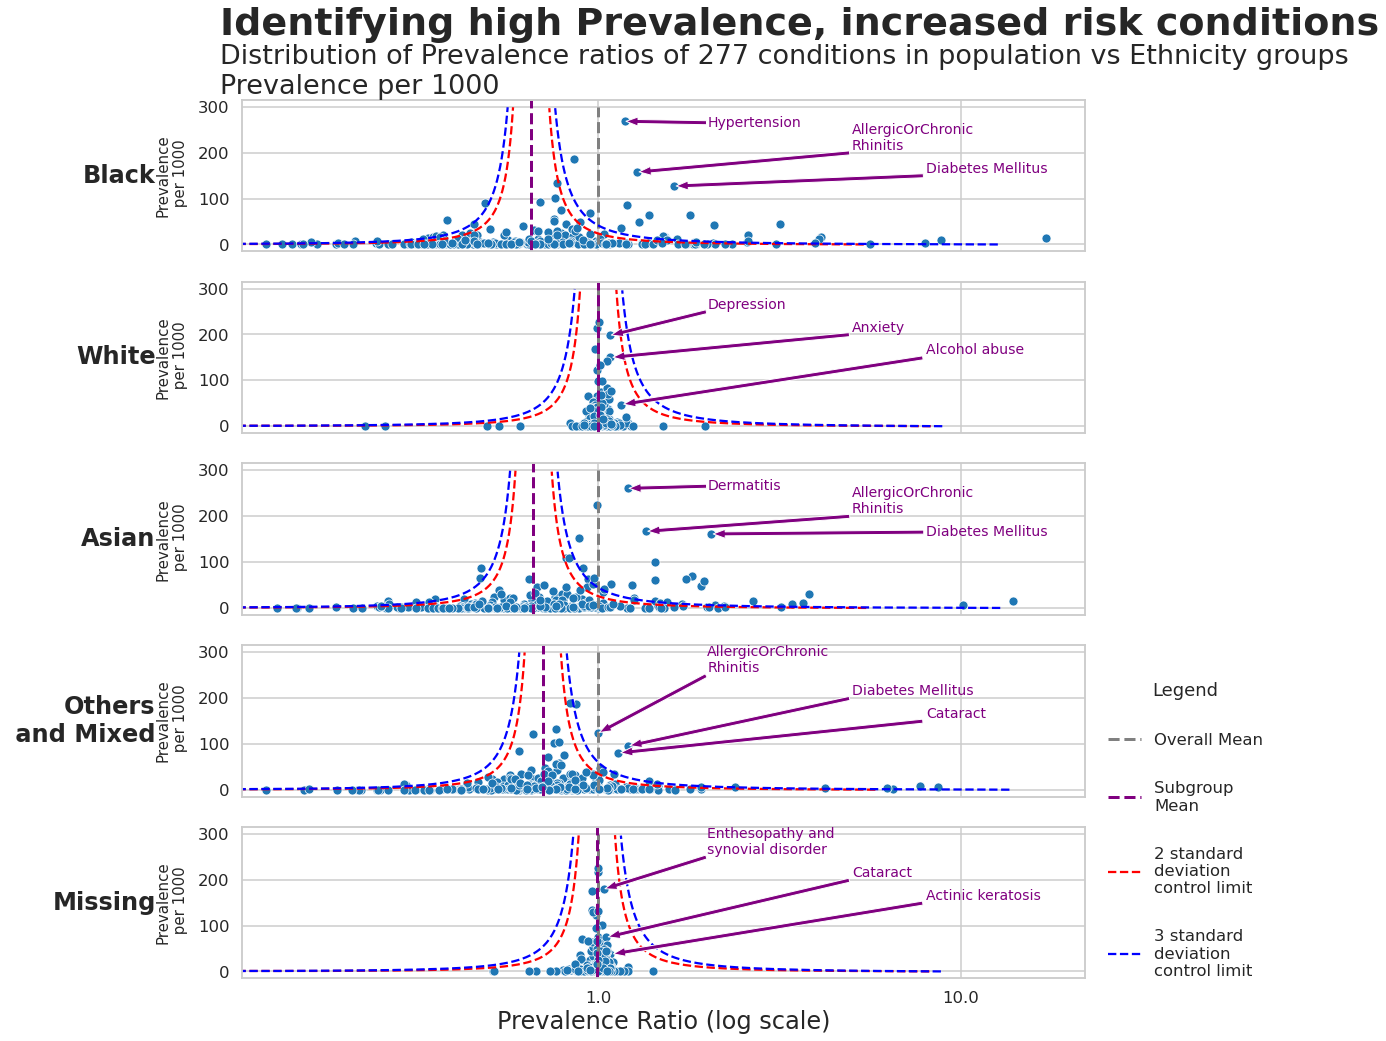

In [21]:
ethnicity_labels = ['Black','White','Asian','Others\n and Mixed','Missing']
selecthnicities = ["'BLACK'","'WHITE'", "'ASIAN'",
                  "'OTHERS_AND_MIXED'","'MISSING'"]

eth_label_dict = dict(zip(selecthnicities,
                         ethnicity_labels))

risk_threshold = 18 #5.5
measure = 'Prevalence'
measure_min = 3
measure_max = 300
date=headline_date
flagged_conditions = [#'Actinic keratosis',
                          'Chronic Obstructive Pulmonary Disease',
                          'Depression',
                          'Obesity',
                        'Substance Misuse']

fig, axs = funnel_plot_n_variables(eth_label_dict,
                       df=df,
                       category_label='Ethnicity',
                       risk_threshold=risk_threshold,
                        denominator = ' per 1000',
                       measure=measure,
                       measure_min = measure_min,
                       measure_max = measure_max,
                        flagged_conditions = [],
                       date=date,
                        label_n_conditions=3,
                                  text_coord_options = [(2, measure_max*5/6),
                                  (5, measure_max*4/6),
                                  (8, measure_max*3/6),
                                  (13, measure_max*2/6),
                                  (21, measure_max*1/6),
                                  (13, measure_max*5/6)])



In [22]:
date_mask = df.Date== '2019'
group_mask = df.Group== "'BLACK'"
#measure_mask = df.Measure== 'Prevalence'
df.loc[date_mask&group_mask].sort_values(by='Prevalence Z-Score').tail(15)

,Unnamed: 0,Condition,Date,Group,Prevalence,Prevalence Ratio,Expected Prevalence,Prevalence Z-Score,Incidence,Incidence Ratio,Expected Incidence,Incidence Z-Score
74776,74776,Thalassaemia Trait,2019,'BLACK',9.432804,8.776443,0.702152,3.316022,41.961173,9.975178,3.035731,7.669232
74585,74585,Dermatitis,2019,'BLACK',185.221244,0.860873,140.559715,3.375830,864.051521,1.177759,529.443466,12.244498
74635,74635,Iron Deficiency Anaemia,2019,'BLACK',49.747491,1.296129,25.074470,3.757042,419.810501,1.418657,213.556234,11.088158
74524,74524,Agranulocytosis,2019,'BLACK',15.315872,4.109800,2.434613,3.826428,103.079248,4.851516,15.333103,10.710808
74783,74783,Tuberculosis,2019,'BLACK',20.525263,2.589992,5.177251,3.841485,89.342658,6.719586,9.595169,10.676061
74617,74617,HIV,2019,'BLACK',13.247738,17.158620,0.504392,4.325853,19.140468,8.409816,1.642489,4.908989
74564,74564,Cataract,2019,'BLACK',84.902431,1.204793,46.038004,4.537365,714.977021,0.946538,545.117645,6.605825
74601,74601,Erectile Dysfunction,2019,'BLACK',65.023766,1.381750,30.743380,4.641761,293.668796,1.493881,141.865913,9.809801
74614,74614,Glaucoma,2019,'BLACK',43.359076,2.091315,13.544702,5.162814,180.742569,1.332973,97.853303,6.700626
74671,74671,Other Deficiency Anaemia,2019,'BLACK',64.221745,1.789894,23.440333,5.747854,454.573333,1.611726,203.539637,13.188830


In [23]:
df.Group.unique()

array(["'1'", "'10'", "'2'", "'3'", "'4'", "'5'", "'6'", "'7'", "'8'",
       "'9'", "'Ireland'", "'ASIAN'", "'BLACK'", "'MISSING'",
       "'OTHERS_AND_MIXED'", "'WHITE'", 'Overall', "'East Midlands'",
       "'East of England'", "'London'", "'North East'", "'North West'",
       "'Northern Ireland'", "'Scotland'", "'South East'", "'South West'",
       "'Wales'", "'West Midlands'", "'Yorkshire & The Humber'"],
      dtype=object)

In [24]:
df[(df.Group == "'West Midlands'")
   & (df.Date == '2019')].sort_values('Prevalence Z-Score').replace(
       [np.inf, -np.inf], np.nan).dropna(subset=['Prevalence Z-Score']).head(10)

,Unnamed: 0,Condition,Date,Group,Prevalence,Prevalence Ratio,Expected Prevalence,Prevalence Z-Score,Incidence,Incidence Ratio,Expected Incidence,Incidence Z-Score
157877,157877,Alcohol abuse,2019,'West Midlands',21.199158,0.520786,39.097655,-3.417941,96.008722,0.444244,198.741977,NaN
157974,157974,High Birth Weight,2019,'West Midlands',0.020020,1.050600,0.018302,-2.090076,0.000000,0.000000,0.020622,NaN
158133,158133,Trifascicular Block,2019,'West Midlands',0.165049,1.021726,0.155157,-1.246476,2.060613,0.642776,2.948066,-0.379730
157964,157964,Gastrointestinal Ulcer (excluding oesophageal),2019,'West Midlands',18.136532,0.725245,24.019332,-1.245691,47.783079,0.775107,56.690884,-1.206531
158136,158136,Tubulo-interstitial Nephropathy,2019,'West Midlands',0.141034,1.947319,0.069563,-1.221117,1.365182,2.118144,0.592701,0.080206
158046,158046,Primary Malignancy - Biliary,2019,'West Midlands',0.162669,1.264376,0.123572,-1.211987,0.874450,0.123844,6.493213,-3.702373
158105,158105,Secondary Pulmonary Hypertension,2019,'West Midlands',0.230628,1.071652,0.206705,-1.098304,0.000000,0.000000,2.940767,NaN
157923,157923,Chronic Fatigue Syndrome,2019,'West Midlands',13.148688,0.720723,17.522888,-1.065756,76.049400,0.902187,77.517567,-0.129887
158062,158062,Primary Malignancy - Pancreas,2019,'West Midlands',0.242359,1.130507,0.205910,-1.063551,8.901849,0.521208,15.706145,-1.968236
158109,158109,Sickle Cell Disease,2019,'West Midlands',0.202905,1.734859,0.112336,-1.058022,0.703132,3.877868,0.166742,-0.182119


In [25]:
flagged_conditions_imd10_prev = ['Obesity','Depression','Secondary Malignancy - Bowel',
                         'Substance Misuse','Secondary Malignancy - Peritoneum',
                         'Trifascicular Block','Diabetes Mellitus','Folate Deificiency Anaemia',
                         'Enteropathic Arthropathy','B12 Deficiency'] #loads of cancers
flagged_conditions_imd10_inc = ['Secondary Malignancy - Pleura','Secondary Malignancy - Bowel',
                               'Sepsis of the Newborn','Patent Ductus Arteriosus','Tubulo-interstitial Nephropathy',
                               'Atrioventricular Block third degree','Hodgkins Lymphoma','Rheumatic Fever',
                               'Myasthenia Gravis','HIV']
flagged_conditions_imd1_prev = ['Sepsis of the Newborn','Actinic keratosis','Tubulo-interstitial Nephropathy',
                               'Secondary Malignancy - Bowel','Atrioventricular Block second degree',
                               'Primary Malignancy - Liver','Enthesopathy and synovial disorder',
                               'Primary Malignancy - Skin',] #lots of liver/pancreas
flagged_conditions_imd1_inc = ['Sepsis of the Newborn','Neonatal Jaundice','Secondary Pulmonary Hypertension',
                              'Down Syndrome','Cerebral Palsy','Spina Bifida','Cystic fibrosis',
                               'Idiopathic Intracranial Hypertension','Thalassaemia','Portal Hypertension',
                              'Angiodysplasia of colon']

In [26]:
flagged_conditions_merged = [flagged_conditions_imd10_prev,
                                    flagged_conditions_imd10_inc,
                                    flagged_conditions_imd1_prev,
                                    flagged_conditions_imd1_inc]
flagged_conditions_flat = [item for sublist in flagged_conditions_merged for item in sublist]

## IMD Graph

2019 '1' Prevalence geometric mean=  0.9945254628794816
2019 '2' Prevalence geometric mean=  0.9590860848129288
2019 '3' Prevalence geometric mean=  0.9769319486998136
2019 '4' Prevalence geometric mean=  0.9731888604937254
2019 '5' Prevalence geometric mean=  0.9782432217690078
2019 '6' Prevalence geometric mean=  0.9398875768360988
2019 '7' Prevalence geometric mean=  0.9494839847696368
2019 '8' Prevalence geometric mean=  0.9343155574209272
2019 '9' Prevalence geometric mean=  1.0445937212415917
2019 '10' Prevalence geometric mean=  1.0111524442696929


(<Figure size 1080x1908 with 10 Axes>,
 array([<AxesSubplot:xlabel='Prevalence Ratio', ylabel='Prevalence\n Per 1000'>,
        <AxesSubplot:xlabel='Prevalence Ratio', ylabel='Prevalence\n Per 1000'>,
        <AxesSubplot:xlabel='Prevalence Ratio', ylabel='Prevalence\n Per 1000'>,
        <AxesSubplot:xlabel='Prevalence Ratio', ylabel='Prevalence\n Per 1000'>,
        <AxesSubplot:xlabel='Prevalence Ratio', ylabel='Prevalence\n Per 1000'>,
        <AxesSubplot:xlabel='Prevalence Ratio', ylabel='Prevalence\n Per 1000'>,
        <AxesSubplot:xlabel='Prevalence Ratio', ylabel='Prevalence\n Per 1000'>,
        <AxesSubplot:xlabel='Prevalence Ratio', ylabel='Prevalence\n Per 1000'>,
        <AxesSubplot:xlabel='Prevalence Ratio', ylabel='Prevalence\n Per 1000'>,
        <AxesSubplot:xlabel='Prevalence Ratio (log scale)', ylabel='Prevalence\n Per 1000'>],
       dtype=object))

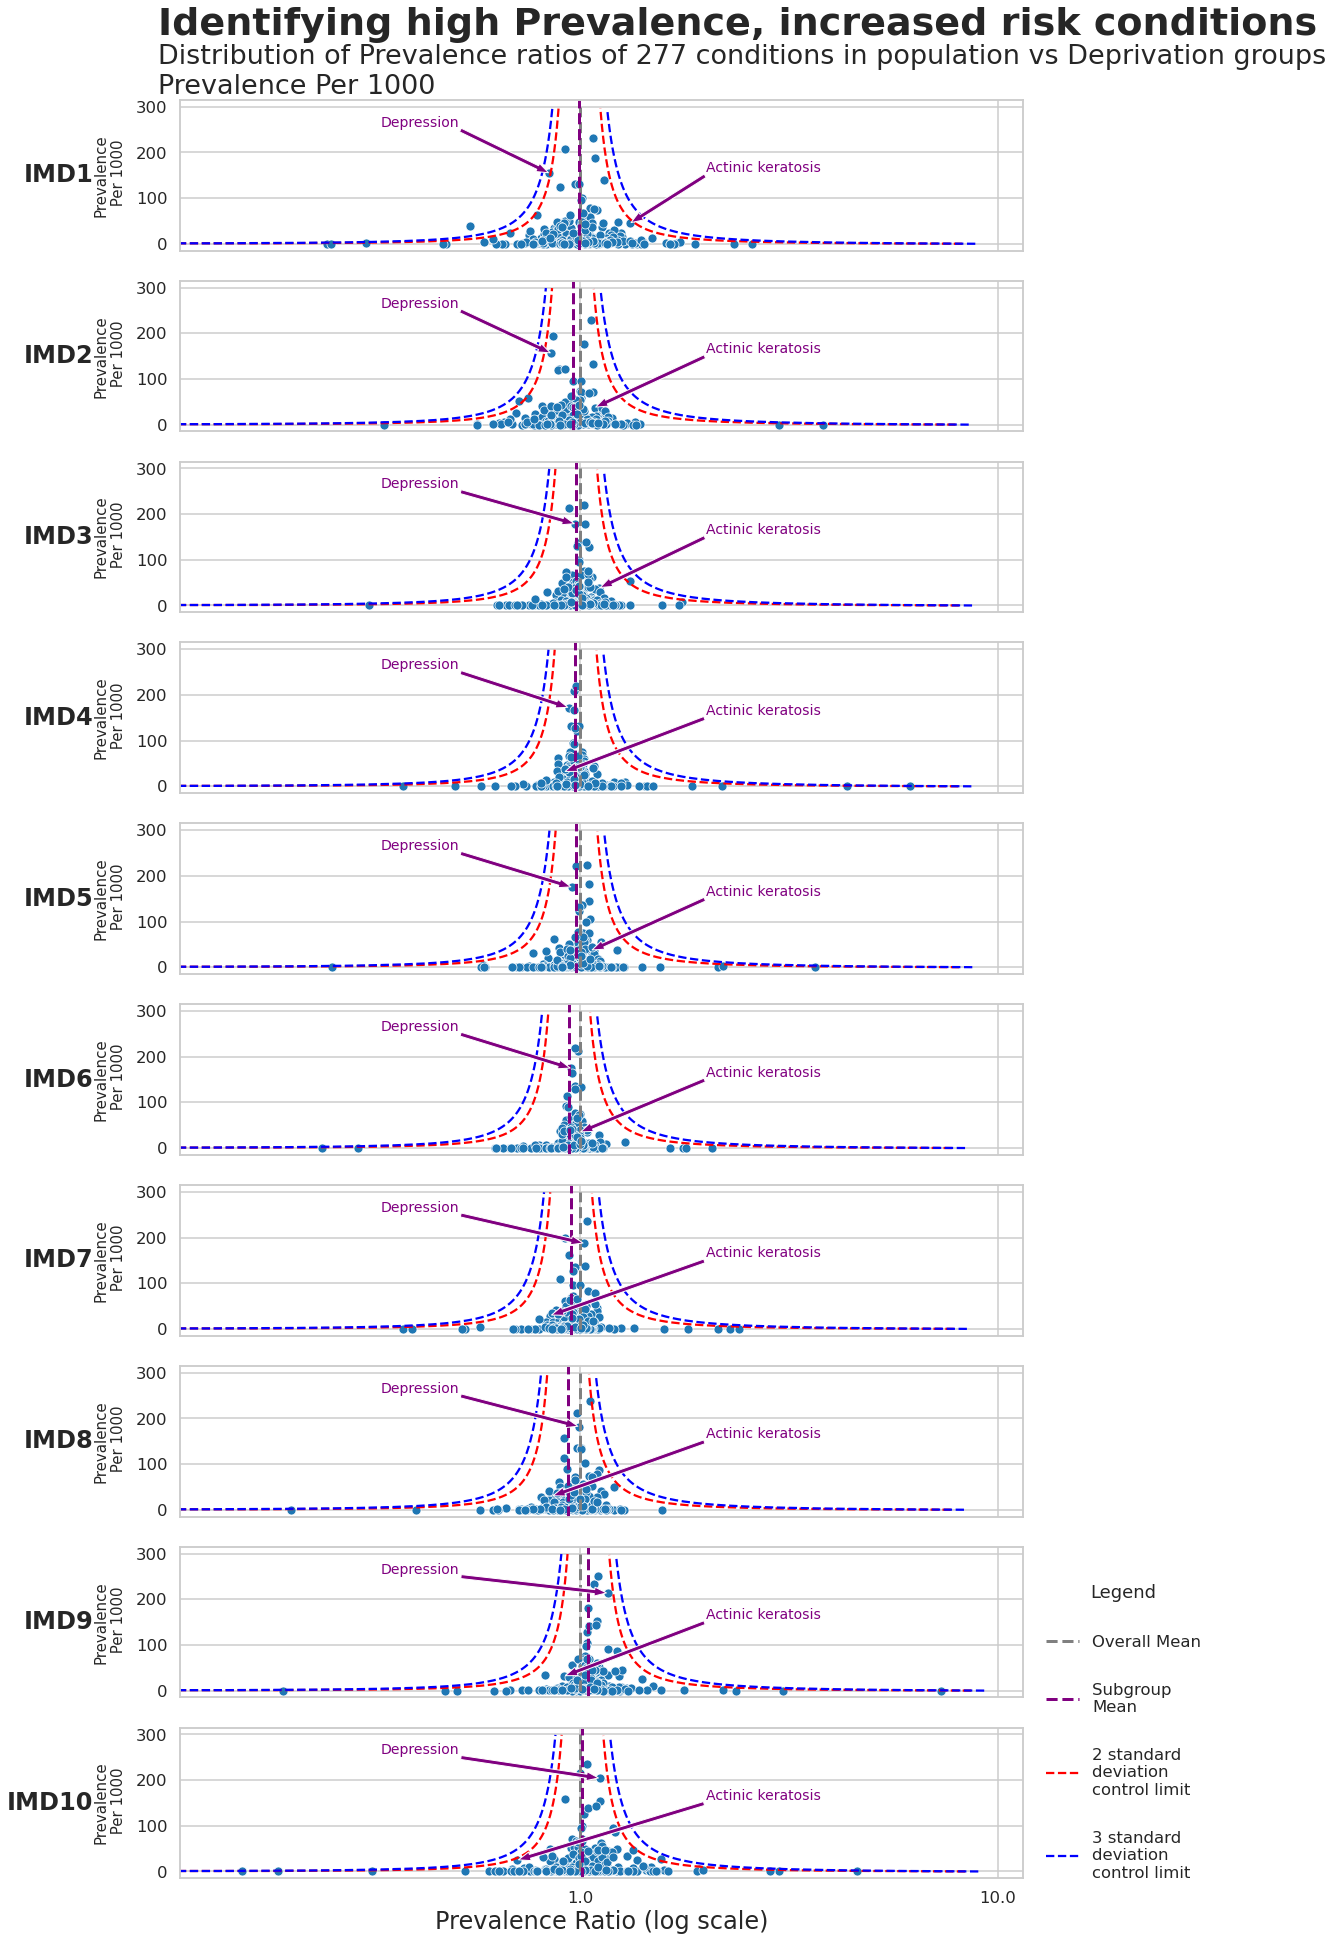

In [27]:
dep_labels = ['IMD1',
             'IMD2',
             'IMD3',
             'IMD4',
             'IMD5',
             'IMD6',
             'IMD7',
             'IMD8',
             'IMD9',
             'IMD10']
selectrivation = ["'1'",
                  "'2'",
                  "'3'",
                  "'4'",
                  "'5'", 
                  "'6'",
                  "'7'",
                  "'8'",
                  "'9'",
                  "'10'"]

dep_label_dict = dict(zip(selectrivation,
                         dep_labels))

risk_threshold = 10 #5.5
measure = 'Prevalence'
measure_min = 3
measure_max = 300
date=headline_date
flagged_conditions = ['Actinic keratosis',
                          #'Chronic Obstructive Pulmonary Disease',
                          'Depression',
                          #'Obesity',
                      #'Substance Misuse'
                     ]

funnel_plot_n_variables(dep_label_dict,
                       df=df,
                       category_label='Deprivation',
                       risk_threshold=risk_threshold,
                       measure=measure,
                        denominator = ' Per 1000',
                       measure_min = measure_min,
                       measure_max = measure_max,
                        flagged_conditions= flagged_conditions,
                       date=date,
                        label_n_conditions=3,
                        text_coord_options = [(1/3, measure_max*5/6),
                                  (2, measure_max*3/6),
                                  (8, measure_max*3/6),
                                  (13, measure_max*2/6),
                                  (21, measure_max*1/6),
                                  (13, measure_max*5/6)])

## Region Graph

2019 'East of England' Prevalence geometric mean=  1.2772618849144262
2019 'London' Prevalence geometric mean=  0.8269580442234182
2019 'North West' Prevalence geometric mean=  0.9642013818092412
2019 'Northern Ireland' Prevalence geometric mean=  1.088874431832295
2019 'Scotland' Prevalence geometric mean=  0.995325998076838
2019 'South East' Prevalence geometric mean=  0.8508869110390646
2019 'South West' Prevalence geometric mean=  1.0444616896249217
2019 'Wales' Prevalence geometric mean=  0.9877682249561168
2019 'West Midlands' Prevalence geometric mean=  0.9604869856544818
2019 'Yorkshire & The Humber' Prevalence geometric mean=  0.6628544912560154


(<Figure size 1080x1908 with 10 Axes>,
 array([<AxesSubplot:xlabel='Prevalence Ratio', ylabel='Prevalence\n Per 1000'>,
        <AxesSubplot:xlabel='Prevalence Ratio', ylabel='Prevalence\n Per 1000'>,
        <AxesSubplot:xlabel='Prevalence Ratio', ylabel='Prevalence\n Per 1000'>,
        <AxesSubplot:xlabel='Prevalence Ratio', ylabel='Prevalence\n Per 1000'>,
        <AxesSubplot:xlabel='Prevalence Ratio', ylabel='Prevalence\n Per 1000'>,
        <AxesSubplot:xlabel='Prevalence Ratio', ylabel='Prevalence\n Per 1000'>,
        <AxesSubplot:xlabel='Prevalence Ratio', ylabel='Prevalence\n Per 1000'>,
        <AxesSubplot:xlabel='Prevalence Ratio', ylabel='Prevalence\n Per 1000'>,
        <AxesSubplot:xlabel='Prevalence Ratio', ylabel='Prevalence\n Per 1000'>,
        <AxesSubplot:xlabel='Prevalence Ratio (log scale)', ylabel='Prevalence\n Per 1000'>],
       dtype=object))

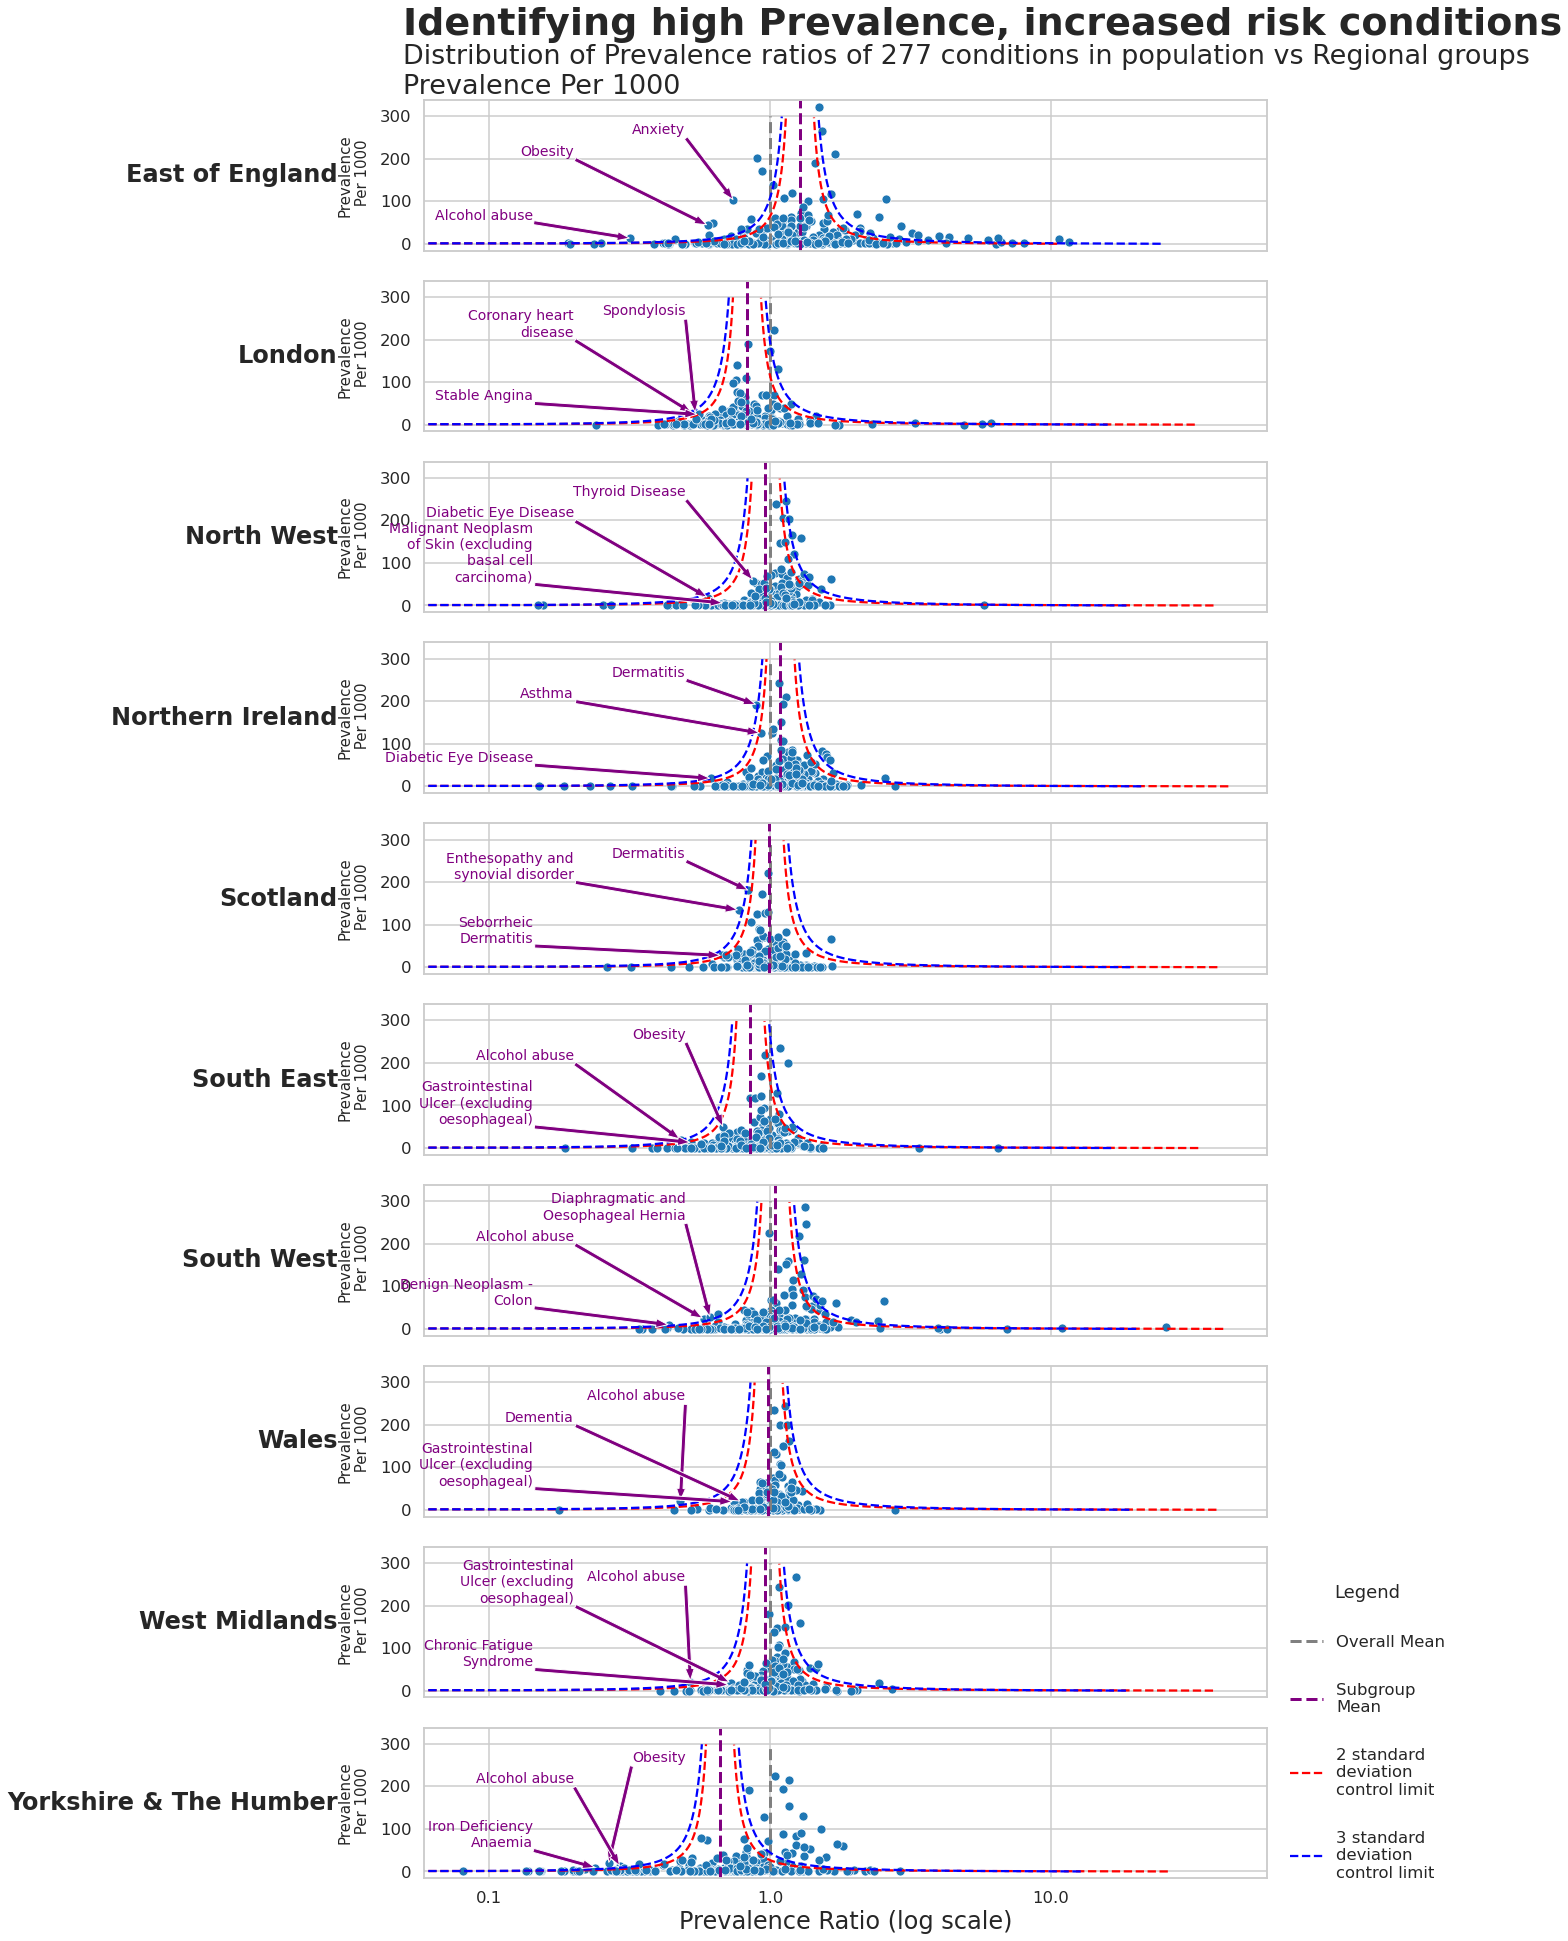

In [28]:
region_labels = [#'East Midlands',#only goes up to 2015
                 'East of England','London',#'North East',# data up to 2017 only
    'North West','Northern Ireland','Scotland','South East',
                'South West','Wales','West Midlands','Yorkshire & The Humber']
region_names = [#"'East Midlands'",
       "'East of England'", "'London'", #"'North East'", 
    "'North West'",
       "'Northern Ireland'", "'Scotland'", "'South East'", "'South West'",
       "'Wales'", "'West Midlands'", "'Yorkshire & The Humber'"]

region_label_dict = dict(zip(region_names,
                         region_labels))

risk_threshold = 50 #5.5
measure = 'Prevalence'
measure_min = 3
measure_max = 300
date=headline_date

funnel_plot_n_variables(region_label_dict,
                       df=df,
                       category_label='Regional',
                       risk_threshold=risk_threshold,
                       measure=measure,
                        denominator = ' Per 1000',
                       measure_min = measure_min,
                       measure_max = measure_max,
                        flagged_conditions= [],#flagged_conditions,
                       date=date,
                       heads=False,
                       text_coord_options = [(1/2, measure_max*5/6),
                                  (1/5, measure_max*4/6),
                                  (1/7, measure_max*1/6),
                                  (13, measure_max*1/6),
                                  (21, measure_max*1/6),
                                  (13, measure_max*5/6)])

In [29]:
df_means[df_means.Group=="'North East'"]

,Measure,Group,Date,Ratio
350,Incidence,'North East',2001,0.973742
351,Incidence,'North East',2002,1.040570
352,Incidence,'North East',2003,1.064698
353,Incidence,'North East',2004,1.036978
354,Incidence,'North East',2005,1.086670
355,Incidence,'North East',2006,1.219593
356,Incidence,'North East',2007,1.102011
357,Incidence,'North East',2008,1.090807
358,Incidence,'North East',2009,1.117247
359,Incidence,'North East',2010,1.181573


In [30]:
df_means[(df_means.Date==date)&
        (df_means.Group=="'East of England'")&
        (df_means.Measure=='Prevalence')]

,Measure,Group,Date,Ratio
883,Prevalence,'East of England',2019,1.277262


# regression model

In [31]:
# predict subgroup prevalence from overall prevalence, condition, subgroup, date?, 
# OLS? Poisson?

In [32]:
overall = df[df.Group=='Overall'][['Condition','Date','Prevalence','Incidence']]
overall.columns = ['Condition','Date','Overall_Prevalence','Overall_Incidence']
df = df.merge(overall, how='left',on=['Condition','Date'])
df = df.drop('Unnamed: 0',
       axis=1)
df.head()

,Condition,Date,Group,Prevalence,Prevalence Ratio,Expected Prevalence,Prevalence Z-Score,Incidence,Incidence Ratio,Expected Incidence,Incidence Z-Score,Overall_Prevalence,Overall_Incidence
0,Abdominal Aortic Aneurysm,2001,'1',0.530342,0.922470,0.520473,-0.815939,9.017216,0.776990,10.696582,-0.439592,0.574914,11.605325
1,Abdominal and Inguinal Hernia,2001,'1',45.055509,1.001975,40.708579,0.556303,336.940302,1.078113,288.055630,2.693790,44.966684,312.527798
2,Acne,2001,'1',44.018789,1.006731,39.584019,0.576658,466.100250,1.031525,416.473224,2.309495,43.724495,451.855288
3,Actinic keratosis,2001,'1',9.627541,1.290095,6.755987,0.742323,206.747025,1.443360,132.023826,5.516654,7.462661,143.240094
4,Agranulocytosis,2001,'1',1.212038,0.933039,1.176012,-0.549693,14.632386,0.735235,18.343260,-0.853587,1.299022,19.901638


In [33]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

/rds/bear-apps/2022a/EL8-ice/software/statsmodels/0.13.1-foss-2022a/lib/python3.10/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [98]:
covariance.head()

,Condition,Date,Group,Prevalence,Overall_Prevalence
0,Abdominal Aortic Aneurysm,2001,'1',0.530342,0.574914
1,Abdominal and Inguinal Hernia,2001,'1',45.055509,44.966684
2,Acne,2001,'1',44.018789,43.724495
3,Actinic keratosis,2001,'1',9.627541,7.462661
4,Agranulocytosis,2001,'1',1.212038,1.299022


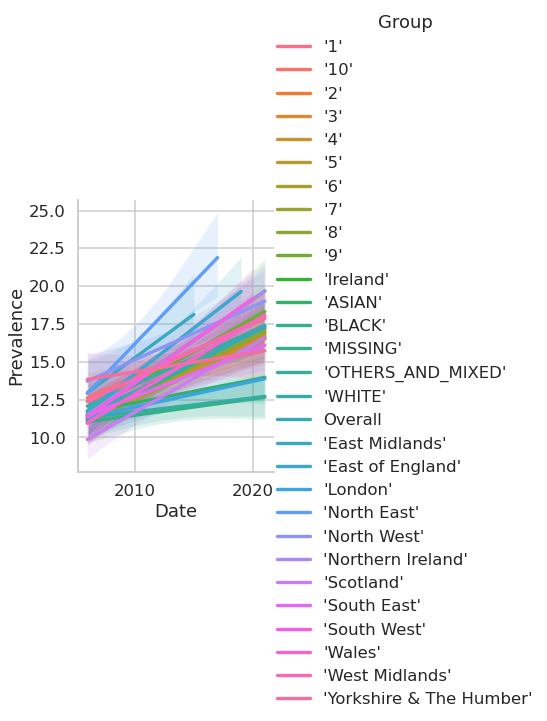

In [110]:
covariance1 = covariance
covariance1.Date = covariance1.Date.astype(int)
sns.lmplot(data=covariance1,y='Prevalence',x='Date',
          scatter=False,
          hue='Group')

In [101]:
covariance = df[['Condition','Date','Group','Prevalence','Overall_Prevalence']]
covariance = covariance[~covariance.Date.isin(['2001','2002','2003','2004','2005'])]
formula = 'Prevalence ~ C(Condition) + C(Date) + C(Group) + Overall_Prevalence'# + ' + '.join(list(covariance.columns[1:]))

results = smf.ols(formula, 
                  data=covariance).fit()

In [102]:
df_coeffs = pd.read_html(results.summary().tables[1].as_html(),header=0,index_col=0)[0]
df_coeffs.loc[[i for i in df_coeffs.index if 'Condition' not in i ]]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.5468,0.274,-1.997,0.046,-1.083,-0.010
C(Date)[T.2007],0.0165,0.086,0.193,0.847,-0.151,0.184
C(Date)[T.2008],0.0093,0.086,0.108,0.914,-0.159,0.177
C(Date)[T.2009],0.0442,0.086,0.515,0.607,-0.124,0.213
C(Date)[T.2010],0.0799,0.086,0.927,0.354,-0.089,0.249
C(Date)[T.2011],0.1121,0.087,1.294,0.196,-0.058,0.282
C(Date)[T.2012],0.1370,0.087,1.575,0.115,-0.033,0.308
C(Date)[T.2013],0.1723,0.087,1.972,0.049,0.001,0.344
C(Date)[T.2014],0.2560,0.088,2.915,0.004,0.084,0.428
C(Date)[T.2015],0.2012,0.088,2.282,0.023,0.028,0.374


In [116]:
df.Date.unique()

array(['2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008',
       '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016',
       '2017', '2018', '2019', '2020', '2021'], dtype=object)

# NHSCore20PLUS5

In [42]:
def lookup_cond_names(search_string = 'stroke',
                 col = 'Joht Labelling',
                 ref_df = condition_labels):
    search_results = [x for x in ref_df[col].dropna() if search_string in x]
    return search_results

def lookup_cond_table(search_string = 'stroke',
                 col = 'Joht Labelling',
                 ref_df = condition_labels):
    search_results = [x for x in ref_df[col].dropna() if search_string in x]
    search_results = ref_df[ref_df[col].isin(search_results)]
        
    return search_results

organ_systems = ['Cancers', 'Diseases of the Circulatory System',
       'Diseases of the Digestive System', 'Musculoskeletal conditions',
       'Diseases of the genitourinary system', '"Haematological/Immunological',
       'Diseases of the Respiratory System', 'Neurological conditions',
       'Mental Health Disorders', 'Diseases of the Eye',
       'Perinatal conditions', 'Skin conditions', 'Benign Neoplasm/CIN',
       'Diseases of the Endocrine System', 'Infectious Diseases',
       'Diseases of the Ear', 'Haematological/Immunological']
lookup_cond_names(search_string='Str')

['Ischaemic Stroke', 'Stroke']

In [43]:
condition_labels['Organ System'].value_counts().index

Index(['Cancers', 'Diseases of the Circulatory System',
       'Diseases of the Digestive System', 'Musculoskeletal conditions',
       'Diseases of the genitourinary system', '"Haematological/Immunological',
       'Diseases of the Respiratory System', 'Neurological conditions',
       'Mental Health Disorders', 'Diseases of the Eye',
       'Perinatal conditions', 'Skin conditions', 'Benign Neoplasm/CIN',
       'Diseases of the Endocrine System', 'Infectious Diseases',
       'Diseases of the Ear', 'Haematological/Immunological'],
      dtype='object')

In [44]:
#conditions:
#cancer, cardiometabolics, COPD
#groups:
#Black, Asian, Mixed, IMD1&2
cardiometabolics = ['Obesity',
                'Diabetes Mellitus - other or not specified',
                 'Diabetic Eye Disease',
                 'Diabetes mellitus with neurological manifestation',
                'Atrial Fibrillation',
                'Heart Failure',
                'Hypertension',
                'Myocardial Infarction',
                'Stable Angina',
                'Stroke',
                'Unstable Angina',
                'Ischaemic Stroke',
               'Transient Ischaemic Attack']
cancers = lookup_cond_table(search_string = 'Can',
                 col = 'Organ System')['Joht Labelling'].values
resp = ['Asthma','Chronic Obstructive Pulmonary Disease']


In [45]:
# line and scatterplot
### y-axis = subgroup estimate
### x-axis = overall estimate
### line of x=y
### chi-squared cloud of confidence interval
###

In [46]:
df.head()

,Condition,Date,Group,Prevalence,Prevalence Ratio,Expected Prevalence,Prevalence Z-Score,Incidence,Incidence Ratio,Expected Incidence,Incidence Z-Score,Overall_Prevalence,Overall_Incidence
0,Abdominal Aortic Aneurysm,2001,'1',0.530342,0.922470,0.520473,-0.815939,9.017216,0.776990,10.696582,-0.439592,0.574914,11.605325
1,Abdominal and Inguinal Hernia,2001,'1',45.055509,1.001975,40.708579,0.556303,336.940302,1.078113,288.055630,2.693790,44.966684,312.527798
2,Acne,2001,'1',44.018789,1.006731,39.584019,0.576658,466.100250,1.031525,416.473224,2.309495,43.724495,451.855288
3,Actinic keratosis,2001,'1',9.627541,1.290095,6.755987,0.742323,206.747025,1.443360,132.023826,5.516654,7.462661,143.240094
4,Agranulocytosis,2001,'1',1.212038,0.933039,1.176012,-0.549693,14.632386,0.735235,18.343260,-0.853587,1.299022,19.901638


In [47]:
df.Group.unique()

array(["'1'", "'10'", "'2'", "'3'", "'4'", "'5'", "'6'", "'7'", "'8'",
       "'9'", "'Ireland'", "'ASIAN'", "'BLACK'", "'MISSING'",
       "'OTHERS_AND_MIXED'", "'WHITE'", 'Overall', "'East Midlands'",
       "'East of England'", "'London'", "'North East'", "'North West'",
       "'Northern Ireland'", "'Scotland'", "'South East'", "'South West'",
       "'Wales'", "'West Midlands'", "'Yorkshire & The Humber'"],
      dtype=object)

## Plotting funcs

In [66]:
def midline(ax,axlim):
    lims = [
            np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
            np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
        ]
    ax.plot([0,axlim], [0,axlim], 'k-', alpha=0.75, zorder=0)

def generate_event_limits(axlim, alpha):
    cis_dict = {}
    #for i in range(0,axlim,0.1):
    #rate, rate_ul, rate_ll = chi2_intervals(alpha,i,denom)
        #cis_dict[i] = chi2_event_intervals(0.05,i)
    events = np.arange(0,axlim,0.1)
    lower_lim_events = ss.chi2.ppf(alpha/2,df=2*events)/2
    upper_lim_events = ss.chi2.ppf(1-alpha/2,df=2*(events+1))/2
    
    midline_cis = pd.DataFrame([events,lower_lim_events,upper_lim_events],index=['Midline','UL','LL']).transpose()
    
    midline_cis.columns = ['Midline','UL','LL']
    
    return midline_cis




def plot2x2(subgroups,
            condition_group,
           axlim=30_000,
           alpha=0.001,
           bbox_to_anchor=(1., 2.3,),
           df=df,
           year='2019'):
    fig, axs = plt.subplots(2,2,figsize=(12,12),
                       sharex=True,sharey=True
                       )
    axs = [x for xs in axs for x in xs]
    midline_cis = generate_event_limits(axlim, alpha)
    plt.xlim(0.1,axlim)
    plt.ylim(0.1,axlim)
        
    for i in range(len(axs)):
        mask1 = df.Condition.isin(condition_group)
        mask2 = df.Group==subgroups[i]
        mask3 = df.Date==year
        sns.scatterplot(data=df[mask1&
                        mask2&
                        mask3],x='Overall_Prevalence',y='Prevalence',
                       hue='Condition',
                       ax=axs[i],
                       #legend=False
                       )
        #axs[i].set_xlim(axlim)
        #axs[i].set_ylim(axlim)
        
        midline(axs[i],axlim)
        axs[i].fill_between(midline_cis.Midline.values,midline_cis.UL.values, midline_cis.LL.fillna(0).values
                    , alpha=0.4, zorder=0)
        axs[i].get_legend().remove()
        # now plot both limits against eachother
        #axs[i].set_aspect('equal')
        axs[i].set_title(subgroups[i])
        axs[i].set_yscale('log')
        axs[i].set_xscale('log')
    
    fig.tight_layout()
   # plt.subplots_adjust(wspace=-0.6, hspace=0.15)
    #handles, labels = axs[i].get_legend_handles_labels()
    #fig.legend(handles, labels, loc='right')
    plt.legend(bbox_to_anchor=bbox_to_anchor)
    formXTicks = np.vectorize(lambda x: x.xaxis.set_major_formatter(mpl_ScalarFormatter()))
    formYTicks = np.vectorize(lambda y: y.yaxis.set_major_formatter(mpl_ScalarFormatter()))
    formXTicks(axs)
    formYTicks(axs)
    return fig, axs

midline_cis = generate_event_limits(300, 0.001)

def plot4x2(subgroups,
            condition_groups=[cardiometabolics,cancers],
            axlims=[[1,300],[0.1,45]],
            axlim_max=300,
           alpha=0.001,
           year='2019',
           df=df):
    #fig, axs = plt.subplots(4,2,figsize=(12,24),
    #                   sharex=True,sharey=True
    #                   )
    
    midline_cis = generate_event_limits(axlim_max, alpha)

    fig = plt.figure(figsize=(12,24))
    coln = len(condition_groups)
    rown = len(subgroups)
    
    axs = [ [] for _ in range(rown) ]
    for i in range(coln):
        index=i+1
        axs[0].append(fig.add_subplot(rown, coln, index))
    for i in range(coln*(rown-1)):
            index=i+coln+1
            axs[i//2+1].append(fig.add_subplot(rown, coln, index, sharex = axs[0][(i%2)]))
    #axs = [x for xs in axs for x in xs]
        
    for i in range(coln):
        for j in range(rown):
            subgroup = subgroups[j]
            condition_group = condition_groups[i]
            axlim=axlims[i][1]
            axlim_min=axlims[i][0]
            ax = axs[j][i]
            print(subgroup,['Cardiometabolics','Cancers'][i])
            
            mask1 = df.Condition.isin(condition_group)
            mask2 = df.Group==subgroup
            mask3 = df.Date==year
            
            sns.scatterplot(data=df[mask1&
                            mask2&
                            mask3],x='Overall_Prevalence',y='Prevalence',
                           hue='Condition',
                           ax=ax,
                           #legend=False
                           )
            midline_cis = midline_cis[midline_cis['Midline']<axlim]
            
            midline(ax,axlim)
            ax.fill_between(midline_cis.Midline.values,midline_cis.UL.values, midline_cis.LL.fillna(0).values
                        , alpha=0.4, zorder=0)
            ax.get_legend().remove()
            # now plot both limits against eachother
            #axs[i].set_aspect('equal')
            ax.set_title(subgroup)
            ax.set_xlim(axlim_min,axlim)
            ax.set_ylim(axlim_min,axlim)
            ax.set_yscale('log')
            ax.set_xscale('log')
    
    fig.tight_layout()
    #plt.subplots_adjust(wspace=-0.6, hspace=0.15)
    #handles, labels = axs[i].get_legend_handles_labels()
    #fig.legend(handles, labels, loc='right')
    #plt.legend(bbox_to_anchor=(1., 2.3,))
    formXTicks = np.vectorize(lambda x: x.xaxis.set_major_formatter(mpl_ScalarFormatter()))
    formYTicks = np.vectorize(lambda y: y.yaxis.set_major_formatter(mpl_ScalarFormatter()))
    formXTicks(axs)
    formYTicks(axs)
    return fig, axs

#plot2x2(["'WHITE'","'BLACK'","'1'","'10'"], cardiometabolics)


In [67]:
mask1 = df.Condition.isin(condition_group)
            mask2 = df.Group==subgroup
            mask3 = df.Date=='2019-01-01'

df[mask1&
                            mask2&
                            mask3]

IndentationError: unexpected indent (2984911931.py, line 2)

'WHITE' Cardiometabolics
'BLACK' Cardiometabolics
'1' Cardiometabolics
'10' Cardiometabolics
'WHITE' Cancers
'BLACK' Cancers
'1' Cancers
'10' Cancers


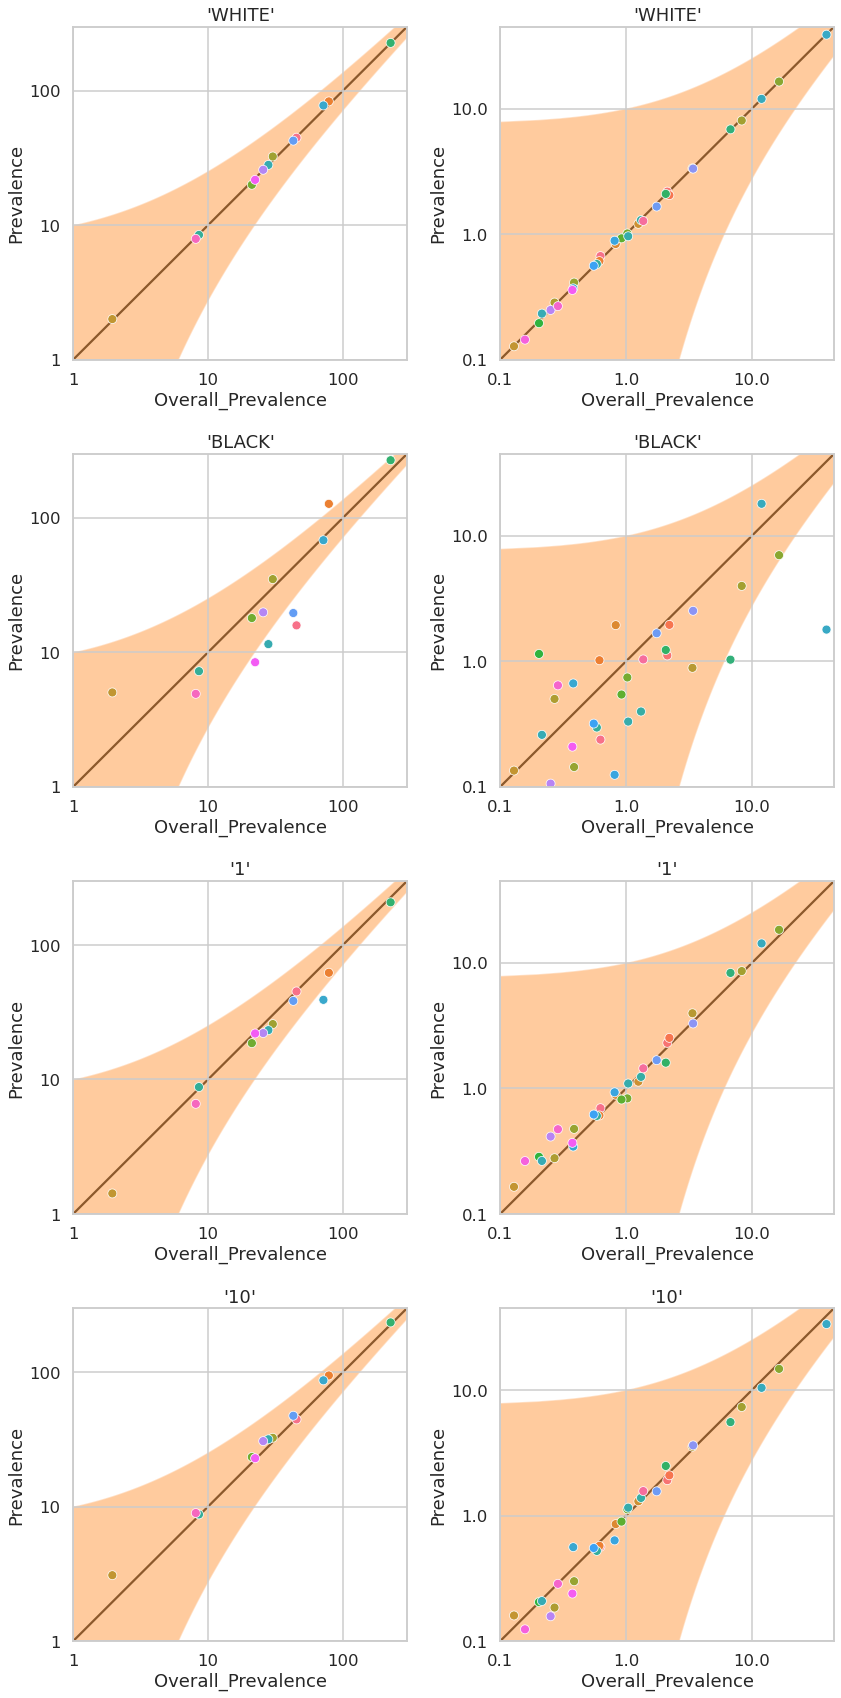

In [68]:
fig, axs = plot4x2(["'WHITE'","'BLACK'","'1'","'10'"],
                    alpha=0.001)

In [ ]:
plot2x2(["'WHITE'","'BLACK'","'ASIAN'","'OTHERS_AND_MIXED'"],
        cancers,
       axlim=300,
       bbox_to_anchor=(1,2.3))

In [ ]:
plot2x2(["'WHITE'","'BLACK'","'ASIAN'","'OTHERS_AND_MIXED'"],
        cardiometabolics,
       axlim=300,
       bbox_to_anchor=(1,1))

## Publication plot

In [69]:
cardiometabolics

organ_system = ['Endocrine','Endocrine','Endocrine','Neurological',
 'Cardiac','Cardiac','Cardiac','Cardiac','Cardiac',
 'Neurological',
'Cardiac',
'Neurological','Neurological']

flagged_conditions = ['Hypertension','Stroke','Myocardial Infarction','Diabetes Mellitus - other or not specified']

dict(zip(cardiometabolics,organ_system))

{'Obesity': 'Endocrine',
 'Diabetes Mellitus - other or not specified': 'Endocrine',
 'Diabetic Eye Disease': 'Endocrine',
 'Diabetes mellitus with neurological manifestation': 'Neurological',
 'Atrial Fibrillation': 'Cardiac',
 'Heart Failure': 'Cardiac',
 'Hypertension': 'Cardiac',
 'Myocardial Infarction': 'Cardiac',
 'Stable Angina': 'Cardiac',
 'Stroke': 'Neurological',
 'Unstable Angina': 'Cardiac',
 'Ischaemic Stroke': 'Neurological',
 'Transient Ischaemic Attack': 'Neurological'}

In [74]:
def get_annotation_texts(flagged_conditions,
                  df_graph,
                  measure='Prevalence',
                  measure_min=0):
        if len(flagged_conditions)==0:  
            if heads:
                df_graph = df_graph[df_graph[measure]>measure_min]  
                conditions_of_interest = df_graph[df_graph.Condition.isin(
                                                 df_graph.sort_values(measure +' Z-Score',
                                                                  ascending=False).head(label_n_conditions)[condition_col]
                                                 )]
            else:
                df_graph = df_graph[df_graph[measure]>measure_min]  
                conditions_of_interest = df_graph[df_graph.Condition.isin(
                                                 df_graph.sort_values(measure +' Z-Score',
                                                                  ascending=False).tail(label_n_conditions)[condition_col]
                                                 )]                
        
        elif len(flagged_conditions)>0:
            df_graph = df_graph[df_graph[measure]>measure_min]
            conditions_of_interest = df_graph[df_graph.Condition.isin(flagged_conditions)] #df should be one subgroup,one year, all conditions

        TEXTS = []
        coord_counter = 0
        for index in conditions_of_interest.index: #iterate through each condition
            condition = conditions_of_interest.loc[index] #series for one condition, one subgroup, one year
            x = condition[f"Overall_{measure}"]
            y = condition[measure]
            text = condition[condition_col]
            if text == "Diabetes Mellitus - other or not specified":
                text = "Diabetes Mellitus"
            if len(text)>14:
                #iter = re.finditer(r"\s", text)
                #indices = [m.start(0) for m in iter]
                #print(indices)
                #spaces = [space for space in indices if space >=15 and space <20 or space >=30 and space <35]
                #for loc in spaces:
                #    text = text[:loc] + '\n' + text[(loc+1):]
                text = textwrap.fill(text, width=20)
            TEXTS.append((text,x,y))
            
        #TEXTS = sorted(TEXTS, key=lambda tup: tup[2],reverse=True)

        return TEXTS

def annotate_graph(TEXTS,ax,text_coord_options,heads=True):
        
        if heads:
            halign = 'left'
        else:
            halign = 'right'
        coord_counter = 0
        for point in TEXTS:
            text,x,y = point
            x_t,y_t = text_coord_options[coord_counter]
            ax.annotate(text,
                            xy=(x, y), xycoords='data',
                            xytext=(x_t, y_t), textcoords='data',color='purple',fontsize=14,
                            arrowprops=dict(facecolor='purple', shrink=0.01,headwidth=8,width=3,
                                       edgecolor="white",linewidth=1),
                            bbox=dict(pad=-2, facecolor="none", edgecolor="none"),
                        horizontalalignment=halign, verticalalignment='bottom')
            coord_counter +=1
        return TEXTS

In [71]:
df.head()

,Condition,Date,Group,Prevalence,Prevalence Ratio,Expected Prevalence,Prevalence Z-Score,Incidence,Incidence Ratio,Expected Incidence,Incidence Z-Score,Overall_Prevalence,Overall_Incidence
0,Abdominal Aortic Aneurysm,2001,'1',0.530342,0.922470,0.520473,-0.815939,9.017216,0.776990,10.696582,-0.439592,0.574914,11.605325
1,Abdominal and Inguinal Hernia,2001,'1',45.055509,1.001975,40.708579,0.556303,336.940302,1.078113,288.055630,2.693790,44.966684,312.527798
2,Acne,2001,'1',44.018789,1.006731,39.584019,0.576658,466.100250,1.031525,416.473224,2.309495,43.724495,451.855288
3,Actinic keratosis,2001,'1',9.627541,1.290095,6.755987,0.742323,206.747025,1.443360,132.023826,5.516654,7.462661,143.240094
4,Agranulocytosis,2001,'1',1.212038,0.933039,1.176012,-0.549693,14.632386,0.735235,18.343260,-0.853587,1.299022,19.901638


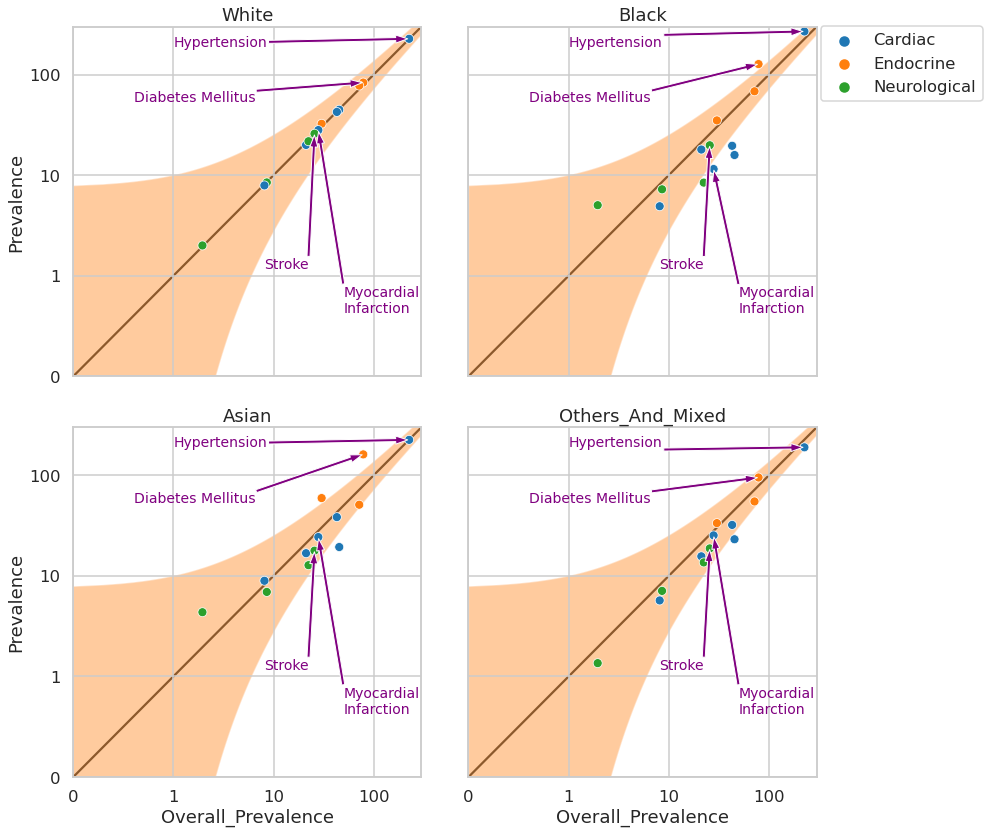

In [85]:
def plot2x2(subgroups,
            condition_group,
           axlim=30_000,
           alpha=0.001,df=df,
           bbox_to_anchor=(1., 2.3,),
           flagged_conditions = flagged_conditions,
           measure='Prevalence',
           year='2019'):
    fig, axs = plt.subplots(2,2,figsize=(12,12),
                       sharex=True,sharey=True
                       )
    df['Organ System'] = df.Condition.map(dict(zip(cardiometabolics,organ_system)))
    axs = [x for xs in axs for x in xs]
    midline_cis = generate_event_limits(axlim, alpha)
    plt.xlim(0.1,axlim)
    plt.ylim(0.1,axlim)
    subgroup_titles = pd.Series(subgroups).str.strip("'").str.title().tolist()
        
    for i in range(len(axs)):
        mask1 = df.Condition.isin(condition_group)
        mask2 = df.Group==subgroups[i]
        mask3 = df.Date==year
        df_graph = df[mask1&mask2&mask3]
        sns.scatterplot(data=df_graph,x=f"Overall_{measure}",y=measure,
                       hue='Organ System',
                       ax=axs[i],
                       #legend=False
                       )
        #axs[i].set_xlim(axlim)
        #axs[i].set_ylim(axlim)
        
        midline(axs[i],axlim)
        axs[i].fill_between(midline_cis.Midline.values,midline_cis.UL.values, midline_cis.LL.fillna(0).values
                    , alpha=0.4, zorder=0)
        axs[i].get_legend().remove()
        # now plot both limits against eachother
        #axs[i].set_aspect('equal')
        axs[i].set_title(subgroup_titles[i])
        axs[i].set_yscale('log')
        axs[i].set_xscale('log')
        TEXTS = get_annotation_texts(flagged_conditions,
                  df_graph=df_graph,
                  measure='Prevalence',
                  measure_min=0)
        
        annotate_graph(TEXTS,ax=axs[i],text_coord_options=[(0.4, 50),#diab
                                  (1, 180),#htn
                                  (50, 0.4),#mi
                                  (8, 1.1),#stroke
                                  ],
                       heads=True)
    
    fig.tight_layout()
   # plt.subplots_adjust(wspace=-0.6, hspace=0.15)
    #handles, labels = axs[i].get_legend_handles_labels()
    #fig.legend(handles, labels, loc='right')
    leg = plt.legend(bbox_to_anchor=bbox_to_anchor)
    formXTicks = np.vectorize(lambda x: x.xaxis.set_major_formatter(mpl_ScalarFormatter()))
    formYTicks = np.vectorize(lambda y: y.yaxis.set_major_formatter(mpl_ScalarFormatter()))
    formXTicks(axs)
    formYTicks(axs)
    return fig, axs, leg

fig1, axs1, leg = plot2x2(["'WHITE'","'BLACK'","'ASIAN'","'OTHERS_AND_MIXED'"],
                    cardiometabolics,
                   axlim=300,
                   bbox_to_anchor=(1.5,2.17))
fig1.savefig(figure_dir + 'Cardiometabolic conditions.png',
            bbox_extra_artists=(leg, axs1[0]),bbox_inches='tight')

In [ ]:
break

# Testing and prototyping

In [ ]:
def funnel_plot_n_variables(group_dict,
                            df,
                            category_label,
                           risk_threshold,
                           measure,
                           measure_min,
                           measure_max,
                           date=df['Date'].max()):
    """create a funnel plot for n number of groups
       inputs: 
    group_dict     a dict of desired groups from the data paired with the label to appear in the graph
    df             the dataframe to select groups from
    category_label Label the category of comparison performed to go in title
    risk_threshold maximum RR to include
    measure        choose incidence or prevalence
    measure_min    choose min rate for measure
    measure_max    choose max rate for measure
        outputs:
    graph funnel plot displaying all conditions with axis per group
    """
    
    group_labels = list(group_dict.keys())
    axis_title_groups = list(group_dict.values())
    
    n_groups = len(group_labels)

    fig, axs = plt.subplots(nrows=n_groups,ncols=1,
                            figsize=(15,9),
                           sharey=True,
                           sharex=True
                           )

    fig.subplots_adjust(left=0.21, right=1.0,
                        top=0.8, bottom=0.0
                       )

    ha_text = 0.20

    #title
    fig.text(
        ha_text, 0.90,
        ''.join(['Identifying high ',measure,', increased risk conditions']),
        fontsize=38, fontweight="bold", fontfamily="Malgun Gothic",
        ha = 'left'
    )

    #subtitle
    fig.text(
        ha_text, 0.81, ''.join(["Distribution of ",
                               measure,
                               " ratios of 277 conditions in population vs ",category_label," groups",
                               '\n',measure,' per 100,000']),
        fontsize=27, #fontfamily="Econ Sans Cnd",
        ha = 'left'
    )

    for i in range(n_groups):
        group = group_labels[i]

        df_graph=df[(df[group_col]==group)&
                                 #(dfx.Prevalence>prevalence_threshold)&
                                 (df[measure +' Ratio']<risk_threshold)&
                                 (df['Date']==date)]

        sns.scatterplot(data=df_graph,
                        y=measure,
                        x=measure + ' Ratio',
                        #hue='Group',
                        ax=axs[i])


        axs[i].vlines(1,ymin=0,ymax=measure_max,
                      color='grey',
                        linestyle='--',
                        linewidth=3)
        #axs[i].yaxis.set_visible(False)
        axs[i].set_ylabel(f"{measure} (%)", fontsize=15, labelpad=10)
        #axs[i].set_xlim(left=0,right=risk_threshold)

        ha_text=0.14
        mid_y_coord = (axs[i].get_position().ymax + axs[i].get_position().ymin)/2

        fig.text(
            ha_text, mid_y_coord,
            group_dict[group],
            fontsize=24, fontweight="bold", fontfamily="Malgun Gothic",
            ha='right',va='center'
        )

        #####################################################################################
        date_mask = df_means.Date == date
        group_mask = df_means.Group == group
        measure_mask = df_means.Measure == measure
        
        
        r = df_means.loc[date_mask&group_mask&measure_mask,'Ratio'].iloc[0]
        
        n = int(df_graph[measure].max())
        #r = ethmeans[eth]

        df_lims2 = generate_limits(n,alpha=0.05)*r
        df_lims3 = generate_limits(n,alpha=0.01)*r
        rUL2 = df_lims2[df_lims2.Rate_UL<risk_threshold].Rate_UL
        rLL2 = df_lims2[df_lims2.Rate_LL<risk_threshold].Rate_LL
        rUL3 = df_lims3[df_lims3.Rate_UL<risk_threshold].Rate_UL
        rLL3 = df_lims3[df_lims3.Rate_LL<risk_threshold].Rate_LL

        # Plot on a single figure containing multiple axes.
        #central ratio
        axs[i].axvline(r,
                    #range(n),
                    color='purple',
                      linestyle='--', lw=3
                    )

        # 2 sigma limits
        drop_n = 1
        colour='red'
        #lower limit controls
        axs[i].plot(rUL2,#.drop(range(drop_n)),
                    range(0,#drop_n,
                          len(rUL2),1),
                      linestyle='--',
                    color=colour)
        #upper limit controls
        axs[i].plot(rLL2,#.drop(range(drop_n)),
                    range(0,#drop_n,
                          len(rLL2),1),
                      linestyle='--',
                    color=colour)

        # 3 sigma limit
        drop_n = 1
        colour='blue'
        #lower limit controls
        axs[i].plot(rUL3,#.drop(range(drop_n)),
                    range(0,#drop_n,
                          len(rUL3),1),
                      linestyle='--',
                    color=colour)
        #upper limit controls
        axs[i].plot(rLL3,#.drop(range(drop_n)),
                    range(0,#drop_n,
                          len(rLL3),1),
                      linestyle='--',
                    color=colour)

        ############################################################################

        df_graph = df_graph[df_graph[measure]>measure_min]
        conditions_of_interest = df_graph[df_graph.Condition.isin(
                                         df_graph.sort_values(measure +' Z-Score',
                                                          ascending=False).head(3)[condition_col]
                                         )]
        sns.despine()
        TEXTS = []
        for index in conditions_of_interest.index:
            condition = conditions_of_interest.loc[index]
            x = condition[measure +' Ratio']
            y = condition[measure]
            text = condition[condition_col]
            if text == "Diabetes Mellitus - other or not specified":
                text = "Diabetes Mellitus"
            if len(text)>14:
                iter = re.finditer(r"\s", text)
                indices = [m.start(0) for m in iter]
                spaces = [space for space in indices if space >=15 and space <20 or space >=30 and space <35]
                for loc in spaces:
                    text = text[:loc] + '\n' + text[(loc+1):]
            TEXTS.append(axs[i].text(x, y, text, color='purple', fontsize=13, fontname="Malgun Gothic"
                                     ))


    # Adjust text position and add arrows ----------------------------
    # 'expand_points' is a tuple with two multipliers by which to expand
    # the bounding box of texts when repelling them from points
    # 'arrowprops' receives a dictionary with all the properties we want
    # for the arrows
        adjust_text(
            TEXTS,
            expand_points=(3.5, 3),
            force_text = (2, 1),
            expand_text = (5, 2),
            #force_explode = (0.001, 0.0001),
            #objects=None,#axs[0].get_children()[0].get_offsets(),
            arrowprops=dict(
                arrowstyle="->",
                color='purple',
                lw=2
            ),
            #only_move={'points':'-x', 'texts':'x-'},
            #explode_radius = 50,
            ax=axs[i],
        )

    plt.xlabel(f"{measure} Ratio (log)",
               fontsize=24)

    log_x = np.vectorize(lambda x: x.set_xscale("log"))
    log_x(axs)

    formTicks = np.vectorize(lambda x: x.xaxis.set_major_formatter(mpl_ScalarFormatter()))
    formTicks(axs)

    #plt.savefig("Funnel_plot " + category_label + ' ' + addendum + ".png", bbox_inches='tight')
    
    #return fig

In [ ]:
funnel_plot_n_variables(group_dict,
                            df,
                            category_label,
                           risk_threshold,
                           measure,
                           measure_min,
                           measure_max,
                           date=df['Date'].max())

In [ ]:
#%% graph ratio vs prevalence with labels

sns.set_context('talk')
sns.set_style('whitegrid')
risk_threshold = 5.5
measure = 'Prevalence'
measure_min = 5
measure_max = 300


fig, axs = plt.subplots(nrows=3,ncols=1,
                        figsize=(15,9),
                       sharey=True,
                       sharex=True
                       )

fig.subplots_adjust(left=0.21, right=1.0,
                    top=0.8, bottom=0.0
                   )

ha_text = 0.20

fig.text(
    ha_text, 0.90,
    ''.join(['Identifying high ',measure,', increased risk conditions']), 
    fontsize=38, fontweight="bold", fontfamily="Malgun Gothic"
)

fig.text(
    ha_text, 0.81, ''.join(["Distribution of ",
                           measure,
                           " ratios of 277 conditions in population vs ethnic groups",
                           '\n',measure,' per 100,000']), 
    fontsize=27, #fontfamily="Econ Sans Cnd"
)

for i in range(3):
    
    df_graph=df[(df[group_col]==selecthnicities[i])&
                             #(dfx.Prevalence>prevalence_threshold)&
                             (df[measure +' Ratio']<risk_threshold)&
                             (df['Date']==df['Date'].max())] 
    
    sns.scatterplot(data=df_graph,
                    y=measure,
                    x=measure + ' Ratio',
                    #hue='Group',
                    ax=axs[i])
    
    
    axs[i].vlines(1,ymin=0,ymax=measure_max,
                  color='grey',
                    linestyle='--',
                    linewidth=3)
    #axs[i].yaxis.set_visible(False)
    axs[i].set_ylabel('')
    axs[i].set_xlim(left=0,right=risk_threshold)
    
    ha_text=0.14
    mid_y_coord = (axs[i].get_position().ymax + axs[i].get_position().ymin)/2
    
    fig.text(        
        ha_text, mid_y_coord,
        ethnicity_labels[i], 
        fontsize=24, fontweight="bold", fontfamily="Malgun Gothic",
        ha='right',va='center'
    )
    df_graph = df_graph[df_graph[measure]>measure_min]
    conditions_of_interest = df_graph[df_graph.Condition.isin(
                                     df_graph.sort_values(measure +' Z-Score',
                                                      ascending=False).head(3)[condition_col]
                                     )]
    
    sns.despine()
    TEXTS = []
    for index in conditions_of_interest.index:
        condition = conditions_of_interest.loc[index]
        #if NAMES[i].startswith("C"):
        x = condition[measure +' Ratio']
        y = condition[measure]
        text = condition[condition_col]
        if len(text)>14:
            iter = re.finditer(r"\s", text)
            indices = [m.start(0) for m in iter]
            spaces = [space for space in indices if space >=15 and space <20 or space >=30 and space <35]
            for loc in spaces:
                text = text[:loc] + '\n' + text[(loc+1):]
        TEXTS.append(axs[i].text(x, y, text, color='purple', fontsize=14, fontname="Malgun Gothic"
                                 ))


# Adjust text position and add arrows ----------------------------
# 'expand_points' is a tuple with two multipliers by which to expand
# the bounding box of texts when repelling them from points

# 'arrowprops' receives a dictionary with all the properties we want
# for the arrows
    adjust_text(
        TEXTS, 
        expand_points=(3, 2),
        force_text = (0.2, 1),
        #force_static = (0.05, 0.1),
        #force_explode = (0.001, 0.0001),
        #objects=None,#axs[0].get_children()[0].get_offsets(),
        arrowprops=dict(
            arrowstyle="->", 
            color='purple', 
            lw=2
        ),
        #only_move={'points':'-x', 'texts':'x-'},
        #explode_radius = 50,
        ax=axs[i]
    )



plt.xlabel(measure +' Ratio', 
           fontsize=24)

In [ ]:
df_graph.columns

plt.xlabel(f"{measure} Ratio (log)",
           fontsize=24)

log_x = np.vectorize(lambda x: x.set_xscale("log"))
log_x(axs)

formTicks = np.vectorize(lambda x: x.xaxis.set_major_formatter(mpl_ScalarFormatter()))
formTicks(axs)

In [ ]:
def flag_conditions(df_graph,
                    measure,
                    measure_min,
                    ax,
                    flagged_conditions = None,
                    n_conditions = 3):
    
    if flagged_conditions==None:  
        df_graph = df_graph[df_graph[measure]>measure_min]  
        conditions_of_interest = df_graph[df_graph.Condition.isin(
                                         df_graph.sort_values(measure +' Z-Score',
                                                          ascending=False).head(n_conditions)[condition_col]
                                         )]

    elif len(flagged_conditions)>1:
        df_graph = df_graph[df_graph[measure]>measure_min]
        conditions_of_interest = df_graph[df_graph.Condition.isin(flagged_conditions)]
    
    TEXTS = []
    little_texts = []
    for index in conditions_of_interest.index:
        condition = conditions_of_interest.loc[index]
        x = condition[measure +' Ratio']
        y = condition[measure]
        text = condition[condition_col]
        if text == "Diabetes Mellitus - other or not specified":
            text = "Diabetes Mellitus"
        if len(text)>14:
            iter = re.finditer(r"\s", text)
            indices = [m.start(0) for m in iter]
            spaces = [space for space in indices if space >=15 and space <20 or space >=30 and space <35]
            for loc in spaces:
                text = text[:loc] + '\n' + text[(loc+1):]
        little_texts.append([x, y, text])
        TEXTS.append(ax.text(x, y, text, color='purple', fontsize=13, fontname="Malgun Gothic"
                                 ))
    print(x)
    print(TEXTS[-1].get_position()[0])
    print(little_texts[-1][0])
        
    return TEXTS,little_texts

In [ ]:
def prep_text(conditions_of_interest):
    TEXTS = []
    little_texts = []
    for index in conditions_of_interest.index:
        condition = conditions_of_interest.loc[index]
        x = condition[measure +' Ratio']
        y = condition[measure]
        text = condition[condition_col]
        if text == "Diabetes Mellitus - other or not specified":
            text = "Diabetes Mellitus"
        if len(text)>14:
            iter = re.finditer(r"\s", text)
            indices = [m.start(0) for m in iter]
            spaces = [space for space in indices if space >=15 and space <20 or space >=30 and space <35]
            for loc in spaces:
                text = text[:loc] + '\n' + text[(loc+1):]
        little_texts.append([x, y, text])
        TEXTS.append(ax.text(x, y, text, color='purple', fontsize=13, fontname="Malgun Gothic"
                                 ))
    return TEXTS,little_texts

In [ ]:
def place_a_text(little_text,ax):
    textus = ax.text(little_text[0], little_text[1], little_text[2], color='purple', fontsize=13, fontname="Malgun Gothic"
                                 )
    return textus

In [ ]:
df_graph = df_graph[df_graph[measure]>measure_min]
conditions_of_interest = df_graph[df_graph.Condition.isin(
                                 df_graph.sort_values(measure +' Z-Score',
                                                  ascending=False).head(3)[condition_col]
                                 )]

TEXTS = []
for index in conditions_of_interest.index:
    condition = conditions_of_interest.loc[index]
    x = condition[measure +' Ratio']
    y = condition[measure]
    text = condition[condition_col]
    if text == "Diabetes Mellitus - other or not specified":
        text = "Diabetes Mellitus"
    if len(text)>14:
        iter = re.finditer(r"\s", text)
        indices = [m.start(0) for m in iter]
        spaces = [space for space in indices if space >=15 and space <20 or space >=30 and space <35]
        for loc in spaces:
            text = text[:loc] + '\n' + text[(loc+1):]
    TEXTS.append(axs[i].text(x, y, text, color='purple', fontsize=13, fontname="Malgun Gothic"
                             ))

In [ ]:
ethnicity_labels = ['Black','White','Asian']
selecthnicities = ["'BLACK'","'WHITE'", "'ASIAN'"]

risk_threshold = 18 #5.5
measure = 'Prevalence'
measure_min = 5
measure_max = 300

flagged_conditions = [#'Actinic keratosis',
                          'Chronic Obstructive Pulmonary Disease',
                          'Depression',
                          'Obesity',
                        'Substance Misuse']

fig, axs = plt.subplots(nrows=3,ncols=1,
                        figsize=(15,9),
                       sharey=True,
                       sharex=True
                       )



fig.subplots_adjust(left=0.21, right=1.0,
                    top=0.8, bottom=0.0
                   )

ha_text = 0.20

fig.text(
    ha_text, 0.90,
    ''.join(['Identifying high ',measure,', increased risk conditions']),
    fontsize=38, fontweight="bold", fontfamily="Malgun Gothic",
    ha = 'left'
)

fig.text(
    ha_text, 0.81, ''.join(["Distribution of ",
                           measure,
                           " ratios of 277 conditions in population vs ethnic groups",
                           '\n',measure,' per 100,000']),
    fontsize=27, #fontfamily="Econ Sans Cnd",
    ha = 'left'
)

for i in range(3):
    eth = selecthnicities[i]

    df_graph=df[(df[group_col]==selecthnicities[i])&
                             #(dfx.Prevalence>prevalence_threshold)&
                             (df[measure +' Ratio']<risk_threshold)&
                             (df['Date']==df['Date'].max())]

    sns.scatterplot(data=df_graph,
                    y=measure,
                    x=measure + ' Ratio',
                    #hue='Group',
                    ax=axs[i])


    axs[i].vlines(1,ymin=0,ymax=measure_max,
                  color='grey',
                    linestyle='--',
                    linewidth=3)
    #axs[i].yaxis.set_visible(False)
    axs[i].set_ylabel(f"{measure} (%)", fontsize=15, labelpad=10)
    #axs[i].set_xlim(left=0,right=risk_threshold)

    ha_text=0.14
    mid_y_coord = (axs[i].get_position().ymax + axs[i].get_position().ymin)/2

    fig.text(
        ha_text, mid_y_coord,
        ethnicity_labels[i],
        fontsize=24, fontweight="bold", fontfamily="Malgun Gothic",
        ha='right',va='center'
    )

    #####################################################################################
    
    n = int(df_graph[measure].max())
    r = ethmeans[eth]

    df_lims2 = generate_limits(n,alpha=0.05)*r
    df_lims3 = generate_limits(n,alpha=0.01)*r
    rUL2 = df_lims2[df_lims2.Rate_UL<risk_threshold].Rate_UL
    rLL2 = df_lims2[df_lims2.Rate_LL<risk_threshold].Rate_LL
    rUL3 = df_lims3[df_lims3.Rate_UL<risk_threshold].Rate_UL
    rLL3 = df_lims3[df_lims3.Rate_LL<risk_threshold].Rate_LL

    # Plot on a single figure containing multiple axes.
    #central ratio
    axs[i].axvline(r,
                #range(n),
                color='purple',
                  linestyle='--', lw=3
                )

    # 2 sigma limits
    drop_n = 1
    colour='red'
    #lower limit controls
    axs[i].plot(rUL2,#.drop(range(drop_n)),
                range(0,#drop_n,
                      len(rUL2),1),
                  linestyle='--',
                color=colour)
    #upper limit controls
    axs[i].plot(rLL2,#.drop(range(drop_n)),
                range(0,#drop_n,
                      len(rLL2),1),
                  linestyle='--',
                color=colour)

    # 3 sigma limit
    drop_n = 1
    colour='blue'
    #lower limit controls
    axs[i].plot(rUL3,#.drop(range(drop_n)),
                range(0,#drop_n,
                      len(rUL3),1),
                  linestyle='--',
                color=colour)
    #upper limit controls
    axs[i].plot(rLL3,#.drop(range(drop_n)),
                range(0,#drop_n,
                      len(rLL3),1),
                  linestyle='--',
                color=colour)

    ############################################################################

    df_debug = df_graph[df_graph.Condition.isin(flagged_conditions)]
    
    df_graph = df_graph[df_graph[measure]>measure_min]
    conditions_of_interest = df_graph[df_graph.Condition.isin(
                                     df_graph.sort_values(measure +' Z-Score',
                                                      ascending=False).head(3)[condition_col]
                                     )]

    TEXTS = []
    for index in conditions_of_interest.index:
        condition = conditions_of_interest.loc[index]
        x = condition[measure +' Ratio']
        y = condition[measure]
        text = condition[condition_col]
        if text == "Diabetes Mellitus - other or not specified":
            text = "Diabetes Mellitus"
        if len(text)>14:
            iter = re.finditer(r"\s", text)
            indices = [m.start(0) for m in iter]
            spaces = [space for space in indices if space >=15 and space <20 or space >=30 and space <35]
            for loc in spaces:
                text = text[:loc] + '\n' + text[(loc+1):]
        TEXTS.append(axs[i].text(x, y, text, color='purple', fontsize=13, fontname="Malgun Gothic"
                                 ))
    

# Adjust text position and add arrows ----------------------------
# 'expand_points' is a tuple with two multipliers by which to expand
# the bounding box of texts when repelling them from points
# 'arrowprops' receives a dictionary with all the properties we want
# for the arrows
    copy_texts = TEXTS
     
    adjust_text(
            TEXTS,
            expand_points=(3.5, 3),
            force_text = (2, 1),
            #expand_text = (5, 2),
            #force_explode = (0.001, 0.0001),
            #objects=None,#axs[0].get_children()[0].get_offsets(),
            arrowprops=dict(
                arrowstyle="->",
                color='purple',
                lw=2
            ),
            #only_move={'points':'-x', 'texts':'x-'},
            #explode_radius = 50,
            ax=axs[i],
            avoid_self =True,
        )     
plt.xlabel(measure +' Ratio', 
           fontsize=24)

plt.xlabel(f"{measure} Ratio (log)",
           fontsize=24)

log_x = np.vectorize(lambda x: x.set_xscale("log"))
log_x(axs)

formTicks = np.vectorize(lambda x: x.xaxis.set_major_formatter(mpl_ScalarFormatter()))
formTicks(axs)
#plt.savefig("Funnel_plot.png", bbox_inches='tight')

In [ ]:
ethnicity_labels = ['Black','White','Asian']
selecthnicities = ["'BLACK'","'WHITE'", "'ASIAN'"]

risk_threshold = 18 #5.5
measure = 'Prevalence'
measure_min = 5
measure_max = 300

flagged_conditions = [#'Actinic keratosis',
                          'Chronic Obstructive Pulmonary Disease',
                          'Depression',
                          'Obesity',
                        'Substance Misuse']

fig, axs = plt.subplots(nrows=3,ncols=1,
                        figsize=(15,9),
                       sharey=True,
                       sharex=True
                       )



fig.subplots_adjust(left=0.21, right=1.0,
                    top=0.8, bottom=0.0
                   )

ha_text = 0.20

fig.text(
    ha_text, 0.90,
    ''.join(['Identifying high ',measure,', increased risk conditions']),
    fontsize=38, fontweight="bold", fontfamily="Malgun Gothic",
    ha = 'left'
)

fig.text(
    ha_text, 0.81, ''.join(["Distribution of ",
                           measure,
                           " ratios of 277 conditions in population vs ethnic groups",
                           '\n',measure,' per 100,000']),
    fontsize=27, #fontfamily="Econ Sans Cnd",
    ha = 'left'
)

for i in range(3):
    eth = selecthnicities[i]

    df_graph=df[(df[group_col]==selecthnicities[i])&
                             #(dfx.Prevalence>prevalence_threshold)&
                             (df[measure +' Ratio']<risk_threshold)&
                             (df['Date']==df['Date'].max())]

    sns.scatterplot(data=df_graph,
                    y=measure,
                    x=measure + ' Ratio',
                    #hue='Group',
                    ax=axs[i])


    axs[i].vlines(1,ymin=0,ymax=measure_max,
                  color='grey',
                    linestyle='--',
                    linewidth=3)
    #axs[i].yaxis.set_visible(False)
    axs[i].set_ylabel(f"{measure} (%)", fontsize=15, labelpad=10)
    #axs[i].set_xlim(left=0,right=risk_threshold)

    ha_text=0.14
    mid_y_coord = (axs[i].get_position().ymax + axs[i].get_position().ymin)/2

    fig.text(
        ha_text, mid_y_coord,
        ethnicity_labels[i],
        fontsize=24, fontweight="bold", fontfamily="Malgun Gothic",
        ha='right',va='center'
    )

    #####################################################################################
    
    n = int(df_graph[measure].max())
    r = ethmeans[eth]

    df_lims2 = generate_limits(n,alpha=0.05)*r
    df_lims3 = generate_limits(n,alpha=0.01)*r
    rUL2 = df_lims2[df_lims2.Rate_UL<risk_threshold].Rate_UL
    rLL2 = df_lims2[df_lims2.Rate_LL<risk_threshold].Rate_LL
    rUL3 = df_lims3[df_lims3.Rate_UL<risk_threshold].Rate_UL
    rLL3 = df_lims3[df_lims3.Rate_LL<risk_threshold].Rate_LL

    # Plot on a single figure containing multiple axes.
    #central ratio
    axs[i].axvline(r,
                #range(n),
                color='purple',
                  linestyle='--', lw=3
                )

    # 2 sigma limits
    drop_n = 1
    colour='red'
    #lower limit controls
    axs[i].plot(rUL2,#.drop(range(drop_n)),
                range(0,#drop_n,
                      len(rUL2),1),
                  linestyle='--',
                color=colour)
    #upper limit controls
    axs[i].plot(rLL2,#.drop(range(drop_n)),
                range(0,#drop_n,
                      len(rLL2),1),
                  linestyle='--',
                color=colour)

    # 3 sigma limit
    drop_n = 1
    colour='blue'
    #lower limit controls
    axs[i].plot(rUL3,#.drop(range(drop_n)),
                range(0,#drop_n,
                      len(rUL3),1),
                  linestyle='--',
                color=colour)
    #upper limit controls
    axs[i].plot(rLL3,#.drop(range(drop_n)),
                range(0,#drop_n,
                      len(rLL3),1),
                  linestyle='--',
                color=colour)

    ############################################################################

    df_debug = df_graph[df_graph.Condition.isin(flagged_conditions)]
    flagged_conditions=[]
    flagged_conditions=['Leiomyoma','Thalassaemia Trait','HIV']
    
    if len(flagged_conditions)<1:  
        df_graph = df_graph[df_graph[measure]>measure_min]  
        conditions_of_interest = df_graph[df_graph.Condition.isin(
                                         df_graph.sort_values(measure +' Z-Score',
                                                          ascending=False).head(3)[condition_col]
                                         )]
        
    elif len(flagged_conditions)>1:
        df_graph = df_graph[df_graph[measure]>measure_min]
        conditions_of_interest = df_graph[df_graph.Condition.isin(flagged_conditions)]
    
    TEXTS = []
    little_texts = []
    for index in conditions_of_interest.index:
        condition = conditions_of_interest.loc[index]
        x = condition[measure +' Ratio']
        y = condition[measure]
        text = condition[condition_col]
        if text == "Diabetes Mellitus - other or not specified":
            text = "Diabetes Mellitus"
        if len(text)>14:
            iter = re.finditer(r"\s", text)
            indices = [m.start(0) for m in iter]
            spaces = [space for space in indices if space >=15 and space <20 or space >=30 and space <35]
            for loc in spaces:
                text = text[:loc] + '\n' + text[(loc+1):]
        little_texts.append([x,y,text])
        TEXTS.append(place_a_text(little_texts[-1],ax=axs[i]))
        #TEXTS.append(axs[i].text(x, y, text, color='purple', fontsize=13, fontname="Malgun Gothic"))

# Adjust text position and add arrows ----------------------------
# 'expand_points' is a tuple with two multipliers by which to expand
# the bounding box of texts when repelling them from points
# 'arrowprops' receives a dictionary with all the properties we want
# for the arrows
    
    adjust_text(
            TEXTS,
            expand_points=(3.5, 3),
            force_text = (2, 1),
            #expand_text = (5, 2),
            #force_explode = (0.001, 0.0001),
            #objects=None,#axs[0].get_children()[0].get_offsets(),
            arrowprops=dict(
                arrowstyle="->",
                color='purple',
                lw=2
            ),
            #only_move={'points':'-x', 'texts':'x-'},
            #explode_radius = 50,
            ax=axs[i],
            avoid_self =True,
        )     
    
plt.xlabel(measure +' Ratio', 
           fontsize=24)

log_x = np.vectorize(lambda x: x.set_xscale("log"))
log_x(axs)

formTicks = np.vectorize(lambda x: x.xaxis.set_major_formatter(mpl_ScalarFormatter()))
formTicks(axs)
#plt.savefig("Funnel_plot.png", bbox_inches='tight')

In [ ]:
axs[i].text(x, y, text, color='purple', fontsize=13, fontname="Malgun Gothic"
                                 )
fig

In [ ]:
df_graph[df_graph.Condition.isin(['Diabetes Mellitus','Diabetic Eye Disease','Tuberculosis'])]

In [ ]:
copy_texts

In [ ]:
little_texts

In [ ]:
TEXTS

In [ ]:
TEXTS,little_texts = flag_conditions(df_graph,
                               measure,
                               measure_min,
                               ax=axs[i],
                               flagged_conditions = flagged_conditions,
                               n_conditions = 3)

In [ ]:
fig,ax = plt.subplots()

ax = sns.scatterplot(data=df_graph,
                    y=measure,
                    x=measure + ' Ratio',
                    #hue='Group',
                    ax=ax)

fig.show()

TEXTS, little_texts = flag_conditions(df_graph,
                               measure,
                               measure_min,
                               ax=ax,
                               flagged_conditions = flagged_conditions,
                               n_conditions = 3)

copy_texts= TEXTS

adjust_text(
        TEXTS,
        expand_points=(3.5, 3),
        force_text = (2, 1),
        expand_text = (5, 2),
        #force_explode = (0.001, 0.0001),
        #objects=None,#axs[0].get_children()[0].get_offsets(),
        arrowprops=dict(
            arrowstyle="->",
            color='purple',
            lw=2
        ),
        #only_move={'points':'-x', 'texts':'x-'},
        #explode_radius = 50,
        ax=ax,
    )

In [ ]:
df_debug #correct x values are being printed, so it's not clear why text is formatting this so strangely

In [ ]:
little_texts

In [ ]:

df_graph[df_graph.Condition.isin(conditions_of_interest)]

In [ ]:
flag_conditions(df_graph,
                    measure,
                    measure_min,
                    axs[i],
                    flagged_conditions = flagged_conditions,
                    n_conditions = 3)

In [ ]:
axs[i].text(x, y, text, color='purple', fontsize=13, fontname="Malgun Gothic"
                                 )

In [ ]:
#def flag_selected_conditions():

conditions_of_interest = ['Actinic keratosis',
                          'Chronic Obstructive Pulmonary Disease',
                          'Depression',
                          'Obesity','Substance Misuse']
conditions_of_interest = df_graph[df_graph.Condition.isin(conditions_of_interest)]

for index in conditions_of_interest.index:
        condition = conditions_of_interest.loc[index]
        x = condition[measure +' Ratio']
        y = condition[measure]
        text = condition[condition_col]
        if text == "Diabetes Mellitus - other or not specified":
            text = "Diabetes Mellitus"
        if len(text)>14:
            iter = re.finditer(r"\s", text)
            indices = [m.start(0) for m in iter]
            spaces = [space for space in indices if space >=15 and space <20 or space >=30 and space <35]
            for loc in spaces:
                text = text[:loc] + '\n' + text[(loc+1):]
        TEXTS.append(axs[i].text(x, y, text, color='purple', fontsize=13, fontname="Malgun Gothic"
                                 ))

In [ ]:
#original

df_graph = df_graph[df_graph[measure]>measure_min]
conditions_of_interest = df_graph[df_graph.Condition.isin(
                                 df_graph.sort_values(measure +' Z-Score',
                                                  ascending=False).head(3)[condition_col]
                                 )]

TEXTS = []
for index in conditions_of_interest.index:
    condition = conditions_of_interest.loc[index]
    x = condition[measure +' Ratio']
    y = condition[measure]
    text = condition[condition_col]
    if text == "Diabetes Mellitus - other or not specified":
        text = "Diabetes Mellitus"
    if len(text)>14:
        iter = re.finditer(r"\s", text)
        indices = [m.start(0) for m in iter]
        spaces = [space for space in indices if space >=15 and space <20 or space >=30 and space <35]
        for loc in spaces:
            text = text[:loc] + '\n' + text[(loc+1):]
    TEXTS.append(axs[i].text(x, y, text, color='purple', fontsize=13, fontname="Malgun Gothic"
                             ))

In [ ]:
df_graph[df_graph.Condition.isin(flagged_conditions)]

In [ ]:
TEXTS